<a href="https://colab.research.google.com/github/UMassIonTrappers/Introduction-to-Quantum-Computing/blob/main/labs/Lab_08_QPU_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [ ]:
import logging
# Suppress all logging from stevedore (which is needed with QISKIT 2.0 for some reason...)
logging.getLogger("stevedore.extension").propagate = False
logging.getLogger("stevedore.extension").disabled = True

In [5]:
try:
  import qiskit
  print('Qiskit imported')
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
  
import qiskit
print('Qiskit version:', qiskit.__version__)

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

try:
  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]

# !pip install --quiet graphviz
# !apt-get install graphviz

Qiskit imported
Qiskit version: 1.4.2
Qiskit Aer imported
Qiskit-IBM-Runtime imported


### Initialize

In [6]:
%matplotlib inline
from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
from scipy import constants
from scipy.optimize import curve_fit

import math
import time
import random

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city, array_to_latex
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

#Qisket imports
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.ibmq import least_busy
# from qiskit.providers.basicaer import BasicAer
# from qiskit.providers.aer.noise import *

from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator

# """Show ALL outputs, not just last expression"""
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Lab 8 - Benchmarking QPUs

# Topics covered:

 * T1 - qubit lifetime
 * T2* - qubit phase coherence time 
 * T2 - qubit phase coherence with echo
 * Gate fidelity benchmarking
 * Randomized Gate Benchmarking
 * GHZ states - multi-particle entangled states
 * GHZ parity contrast decay vs. number of qubits
 * Quantum Volume metric
 * QV computational complexity analysis



# Benchmarking QPUs



https://learning.quantum.ibm.com/tutorial/real-time-benchmarking-for-qubit-selection

In [7]:
# Check if token needs to be set
token = "INSERT YOUR TOKEN HERE"

if token == "INSERT YOUR TOKEN HERE":
    token = input("Please enter your IBM Quantum token: ")

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)

In [9]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

service = QiskitRuntimeService()

backend = FakeBrisbane()
backend.refresh(service)

## T2 - Phase Coherence time

Let's measure the phase coherence time (T2 time) of the qubits on ibm_brisbane

In [10]:
# Parallel Hahn echo function
def parallel_Ramsey(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        # qc.x(q)
        qc.h(q)
        qc.delay(delay , q, unit="s")
        qc.h(q)
        qc.measure(q, q)
    return qc


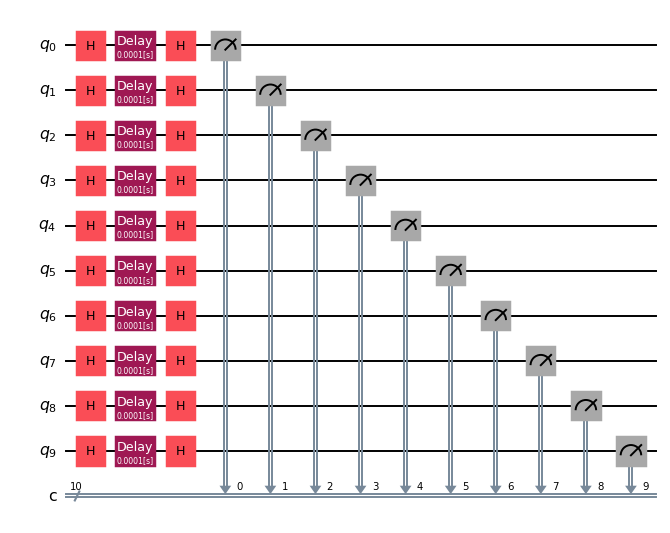

In [11]:
circuit = parallel_Ramsey( 100e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [12]:
backend = FakeBrisbane()
num_qubits = 10
shots = 1000

# Define delays in microseconds (converted to seconds)
delays_us = [1, 50, 100, 200, 300 ,400, 500]
delay_times = [d * 1.0e-6 for d in delays_us]

# Store probabilities per qubit
probs_per_qubit_Ramsey = {q: [] for q in range(num_qubits)}

# Run simulations
for delay in delay_times:
    print(round(delay,6))
    circuit = parallel_Ramsey(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        prob = 1-one_count / shots
        probs_per_qubit_Ramsey[qubit].append(prob)


1e-06
5e-05
0.0001
0.0002
0.0003
0.0004
0.0005



Estimated T₂ values (in µs):
Qubit 0: T₂ ≈ 126.43 µs
Qubit 1: T₂ ≈ 132.78 µs
Qubit 2: T₂ ≈ 32.18 µs
Qubit 3: T₂ ≈ 150.70 µs
Qubit 4: T₂ ≈ 60.46 µs
Qubit 5: T₂ ≈ 363.76 µs
Qubit 6: T₂ ≈ 226.48 µs
Qubit 7: T₂ ≈ 80.55 µs
Qubit 8: T₂ ≈ 129.14 µs
Qubit 9: T₂ ≈ 62.59 µs


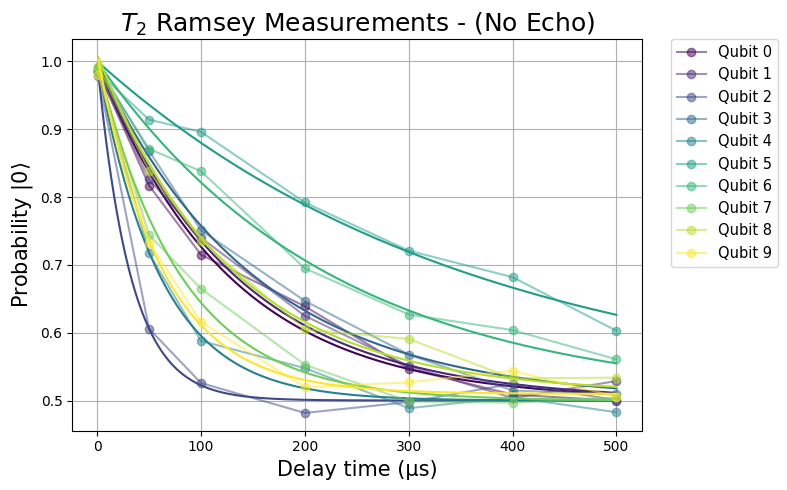

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

# Fit T2 per qubit and store estimates
t2_estimates_Ramsey = {}

for q in range(num_qubits):
    try:
        # Initial parameter guesses and bounds
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit_Ramsey[q],
            p0=[0.5, 50, 0.5],
            bounds=([0.5, 0, 0.5], [0.51, 1000, 0.51])
        )
        t2_estimates_Ramsey[q] = popt  # Store full fit parameters
    except RuntimeError:
        t2_estimates_Ramsey[q] = None

# Print estimated T2 values
print("\nEstimated T₂ values (in µs):")
for q in range(num_qubits):
    params = t2_estimates_Ramsey[q]
    if params is not None:
        print(f"Qubit {q}: T₂ ≈ {params[1]:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")

# Plotting
plt.figure(figsize=(8, 5))
fs = 15
colors = plt.cm.viridis(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    # Plot raw data
    plt.plot(
        delays_us,
        probs_per_qubit_Ramsey[q],
        '-o',
        label=f"Qubit {q}",
        color=colors[q],
        alpha=0.5
    )

    # Plot fitted curve if available
    params = t2_estimates_Ramsey[q]
    if params is not None:
        A, T2, B = params
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(
            t_fit,
            exp_decay(t_fit, A, T2, B),
            '-',
            color=colors[q]
            )

plt.xlabel("Delay time (µs)", fontsize=fs)
plt.ylabel(r'Probability $|0\rangle$', fontsize=fs)
plt.title(r'$T_2$ Ramsey Measurements - (No Echo)', fontsize=fs * 1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
plt.tight_layout()
plt.show()


In [15]:
# Parallel Hahn echo function
def parallel_hahn_echo(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        # qc.x(q)
        qc.h(q)
        qc.delay(delay / 2, q, unit="s")
        qc.x(q)
        qc.delay(delay / 2, q, unit="s")
        qc.h(q)
        qc.measure(q, q)
    return qc

# Exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

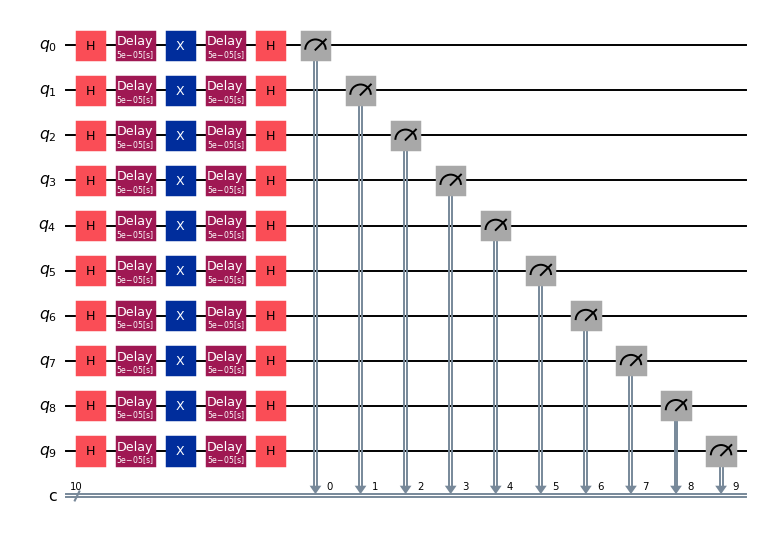

In [16]:
circuit = parallel_hahn_echo( 100e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [18]:
backend = FakeBrisbane()
num_qubits = 10

# Define delays in microseconds (converted to seconds)
delays_us = [1, 50, 100, 200, 300 ,400, 500]
delay_times = [d * 1.0e-6 for d in delays_us]

# Store probabilities per qubit
probs_per_qubit = {q: [] for q in range(num_qubits)}

shots = 1000

# Run simulations
for delay in delay_times:
    print(round(delay,6))
    circuit = parallel_hahn_echo(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        prob = 1-one_count / shots
        probs_per_qubit[qubit].append(prob)


1e-06
5e-05
0.0001
0.0002
0.0003
0.0004
0.0005



Estimated T₂ values (in µs):
Qubit 0: T₂ ≈ 131.42 µs
Qubit 1: T₂ ≈ 159.08 µs
Qubit 2: T₂ ≈ 32.08 µs
Qubit 3: T₂ ≈ 126.56 µs
Qubit 4: T₂ ≈ 69.18 µs
Qubit 5: T₂ ≈ 397.72 µs
Qubit 6: T₂ ≈ 273.47 µs
Qubit 7: T₂ ≈ 81.96 µs
Qubit 8: T₂ ≈ 153.07 µs
Qubit 9: T₂ ≈ 68.38 µs


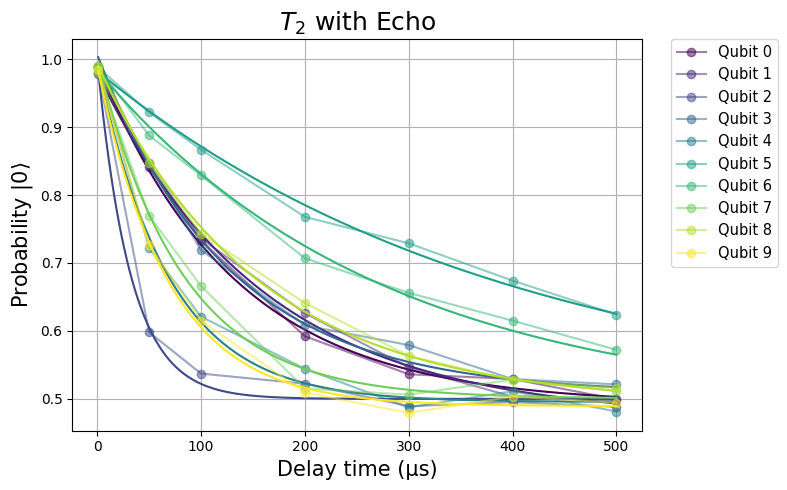

In [19]:
from scipy.optimize import curve_fit

# Define exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

# Fit T2 per qubit and store estimates
t2_estimates = {}

for q in range(num_qubits):
    try:
        # Initial parameter guesses and bounds
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit[q],
            p0=[0.5, 50, 0.5],
            bounds=([0.5, 0, 0.2], [0.51, 1000, 0.7])
        )
        t2_estimates[q] = popt  # Store full fit parameters
    except RuntimeError:
        t2_estimates[q] = None

# Print estimated T2 values
print("\nEstimated T₂ values (in µs):")
for q in range(num_qubits):
    params = t2_estimates[q]
    if params is not None:
        print(f"Qubit {q}: T₂ ≈ {params[1]:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")

# Plotting
plt.figure(figsize=(8, 5))
fs = 15
colors = plt.cm.viridis(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    # Plot raw data
    plt.plot(
        delays_us,
        probs_per_qubit[q],
        '-o',
        label=f"Qubit {q}",
        color=colors[q],
        alpha=0.5
    )

    # Plot fitted curve if available
    params = t2_estimates[q]
    if params is not None:
        A, T2, B = params
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(
            t_fit,
            exp_decay(t_fit, A, T2, B),
            '-',
            color=colors[q]
            )

plt.xlabel("Delay time (µs)", fontsize=fs)
plt.ylabel(r'Probability $|0\rangle$', fontsize=fs)
plt.title(r'$T_2$ with Echo', fontsize=fs * 1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
plt.tight_layout()
plt.show()


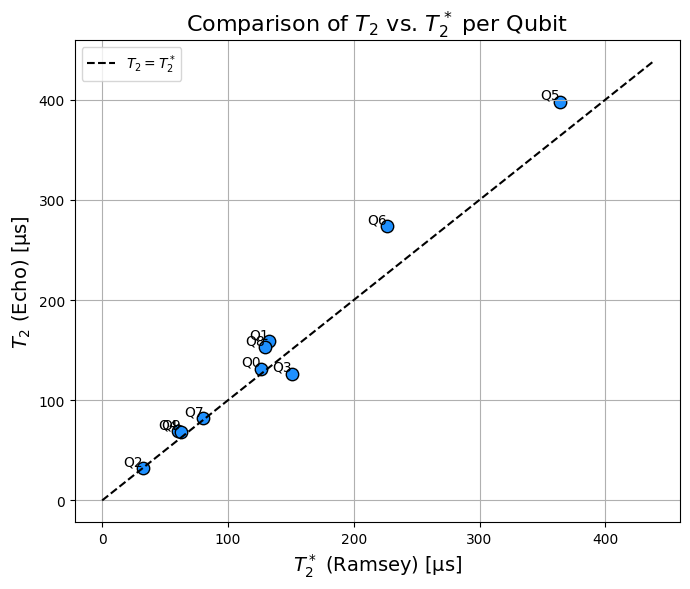

In [20]:
import matplotlib.pyplot as plt

def plot_t2_vs_t2star(t2_estimates, t2_ramsey_estimates):
    t2_vals = []
    t2star_vals = []
    labels = []

    for q in range(len(t2_estimates)):
        t2_fit_echo = t2_estimates[q][1]
        t2_fit = t2_ramsey_estimates[q][1]


        t2_vals.append(t2_fit_echo)
        t2star_vals.append(t2_fit)  # T2* is the second param in [A, T2*, B]
        labels.append(q)

    if len(t2_vals) != len(t2star_vals):
        raise ValueError(f"Mismatch: {len(t2_vals)} echo values vs {len(t2star_vals)} Ramsey values")

    plt.figure(figsize=(7, 6))
    plt.scatter(t2star_vals, t2_vals, c='dodgerblue', edgecolors='k', s=80)

    max_val = max(max(t2_vals), max(t2star_vals)) * 1.1
    plt.plot([0, max_val], [0, max_val], 'k--', label=r"$T_2 = T_2^*$")

    for x, y, q in zip(t2star_vals, t2_vals, labels):
        plt.text(x, y, f"Q{q}", fontsize=10, ha='right', va='bottom')

    plt.xlabel(r"$T_2^*$ (Ramsey) [µs]", fontsize=14)
    plt.ylabel(r"$T_2$ (Echo) [µs]", fontsize=14)
    plt.title(r"Comparison of $T_2$ vs. $T_2^*$ per Qubit", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_t2_vs_t2star(t2_estimates, t2_estimates_Ramsey)


C:\Users\bobni\AppData\Local\Temp\ipykernel_10228\1115440334.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='T2 (µs)', data=data, width=0.5, fliersize=0, palette="pastel")
C:\Users\bobni\AppData\Local\Temp\ipykernel_10228\1115440334.py:21: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='Method', y='T2 (µs)', data=data, jitter=True, size=8,


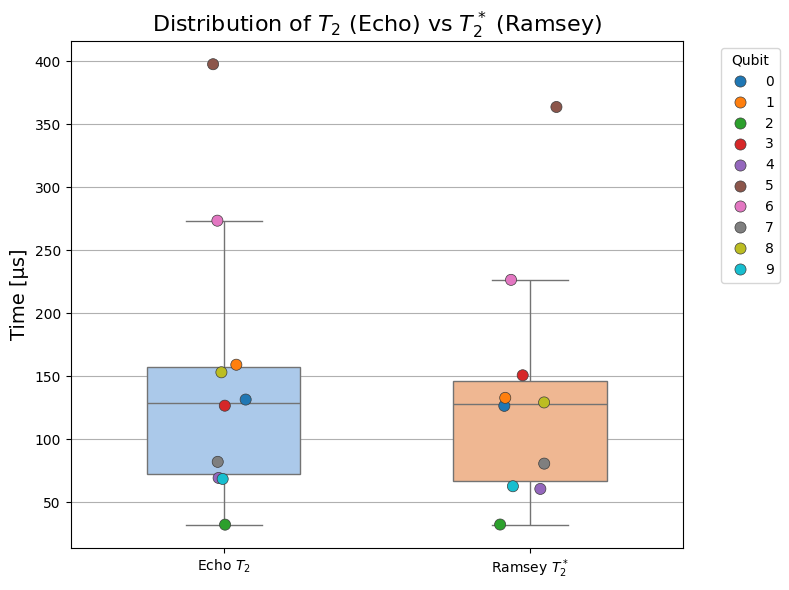

In [21]:
import seaborn as sns

def boxplot_t2_comparison(t2_estimates, t2_estimates_Ramsey, max_us=500):
    # Collect valid and filtered data
    data = {'Method': [], 'T2 (µs)': [], 'Qubit': []}
    for q in t2_estimates:
        t2 = t2_estimates[q][1]
        t2_star = t2_estimates_Ramsey[q][1]
        if t2 and t2 < max_us:
            data['Method'].append('Echo $T_2$')
            data['T2 (µs)'].append(t2)
            data['Qubit'].append(q)
        if t2_star and t2_star < max_us:
            data['Method'].append('Ramsey $T_2^*$')
            data['T2 (µs)'].append(t2_star)
            data['Qubit'].append(q)

    # Create boxplot with scatter overlay
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Method', y='T2 (µs)', data=data, width=0.5, fliersize=0, palette="pastel")
    sns.stripplot(x='Method', y='T2 (µs)', data=data, jitter=True, size=8,
                  hue='Qubit', palette='tab10', dodge=False, marker='o',
                  edgecolor='gray', linewidth=0.5)

    plt.title(r"Distribution of $T_2$ (Echo) vs $T_2^*$ (Ramsey)", fontsize=16)
    plt.ylabel("Time [µs]", fontsize=14)
    plt.xlabel("")
    plt.legend(title="Qubit", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Example usage:
boxplot_t2_comparison(t2_estimates, t2_estimates_Ramsey)


## Plot Map of QPU with errors etc.

In [22]:
from qiskit.visualization import plot_error_map, plot_coupling_map
from qiskit.transpiler import CouplingMap
from graphviz import Graph 


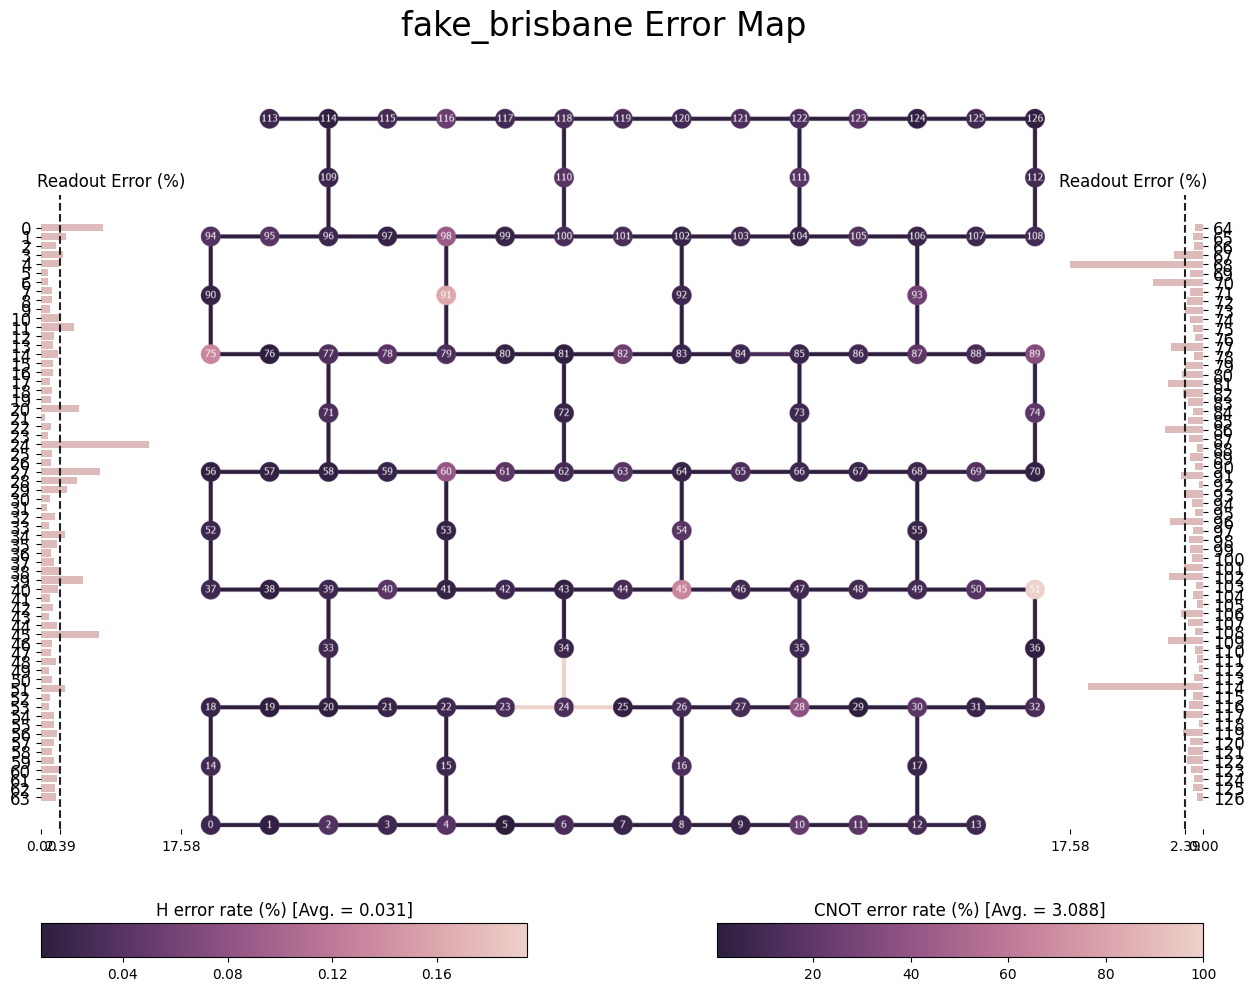

In [23]:
plot_error_map(backend)
# plot_error_map(backend, figsize=(30, 24))

## T1 - Excited State lifetime

Next we can measure T1 (the lifetime of the qubits)

In [24]:
# T1 decay function
def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

# Parallel T1 circuit generator
def parallel_t1(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.x(q)  # excite
        qc.delay(delay, q, unit="s")  # wait
        qc.measure(q, q)
    return qc

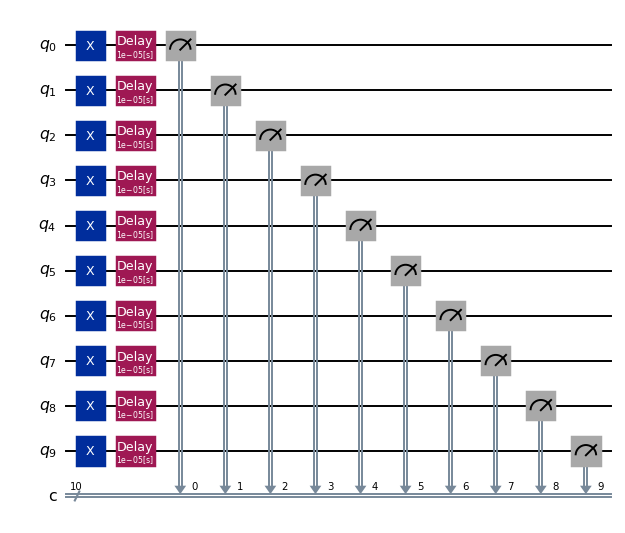

In [25]:
circuit = parallel_t1( 10e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [26]:
backend = FakeBrisbane()
num_qubits = 10  # or more
delays_us = [1, 50, 100, 200, 300, 400 ,500 ]  # microseconds
delay_times = [d * 1e-6 for d in delays_us]  # convert to seconds

shots = 1000
# Run circuits and collect data
probs_per_qubit = {q: [] for q in range(num_qubits)}

for delay in delay_times:
    print(round(delay,6))
    circuit = parallel_t1(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        probs_per_qubit[qubit].append(one_count / shots)


1e-06
5e-05
0.0001
0.0002
0.0003
0.0004
0.0005



Estimated T₁ values (in µs):
Qubit 0: T₁ ≈ 215.68 µs
Qubit 1: T₁ ≈ 272.66 µs
Qubit 2: T₁ ≈ 260.05 µs
Qubit 3: T₁ ≈ 118.55 µs
Qubit 4: T₁ ≈ 190.41 µs
Qubit 5: T₁ ≈ 256.87 µs
Qubit 6: T₁ ≈ 247.94 µs
Qubit 7: T₁ ≈ 130.57 µs
Qubit 8: T₁ ≈ 226.03 µs
Qubit 9: T₁ ≈ 176.84 µs


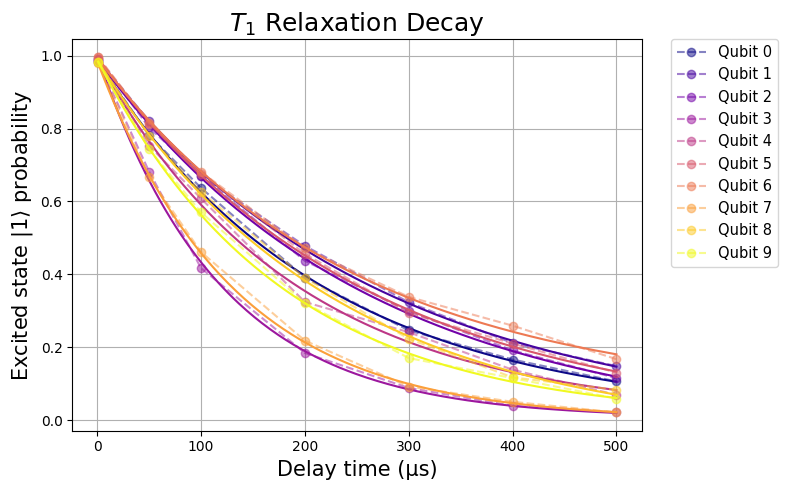

In [33]:
# Define exponential decay model
def exp_decay(t, A, T, B):
    return A * np.exp(-t / T) + B

# Fit T₁ for each qubit and store full fit parameters
t1_estimates = {}

for q in range(num_qubits):
    try:
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit[q],
            p0=[0.9, 50, 0.1]
        )
        t1_estimates[q] = popt  # Save full [A, T1, B]
    except RuntimeError:
        t1_estimates[q] = None

# Print results
print("\nEstimated T₁ values (in µs):")
for q in range(num_qubits):
    fit = t1_estimates[q]
    if fit is not None:
        print(f"Qubit {q}: T₁ ≈ {fit[1]:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")

# Plot decay curves
plt.figure(figsize=(8, 5))
fs = 15
colors = plt.cm.plasma(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    # Plot experimental data
    plt.plot(delays_us, probs_per_qubit[q], 'o--', label=f"Qubit {q}", color=colors[q], alpha=0.5)

    # Plot fitted decay curve if fit succeeded
    fit = t1_estimates[q]
    if fit is not None:
        A, T1, B = fit
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(t_fit, exp_decay(t_fit, A, T1, B), '-', color=colors[q])

plt.xlabel("Delay time (µs)", fontsize=fs)
plt.ylabel(r'Excited state $|1\rangle$ probability', fontsize=fs)
plt.title(r"$T_1$ Relaxation Decay", fontsize=fs * 1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
plt.tight_layout()
plt.show()


# Compare T1 and T2

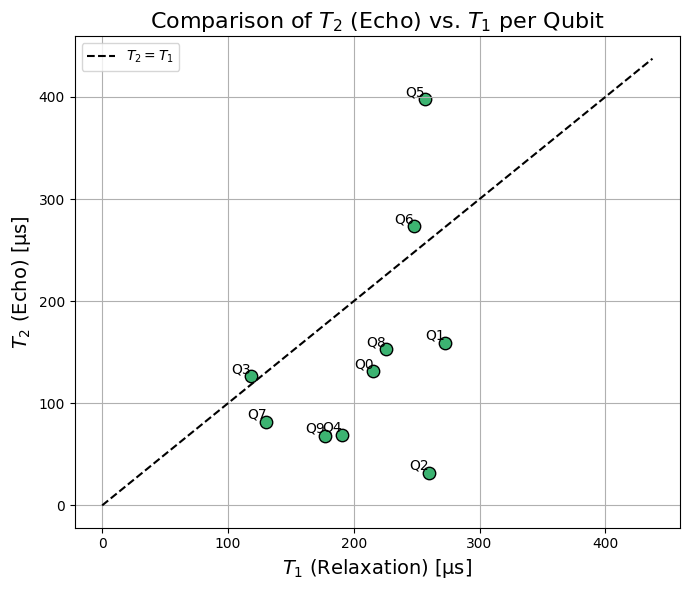

In [35]:
def plot_t2_vs_t1(t2_estimates_echo, t1_estimates):
    t2_vals = []
    t1_vals = []
    labels = []

    for q in range(len(t2_estimates_echo)):
        t2_fit = t2_estimates_echo.get(q)
        t1_fit = t1_estimates.get(q)

        if t2_fit is None or t1_fit is None:
            continue  # Skip qubits where fit failed

        t2_vals.append(t2_fit[1])  # T2 (echo)
        t1_vals.append(t1_fit[1])  # T1
        labels.append(q)

    if not t2_vals or not t1_vals:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(t1_vals, t2_vals, c='mediumseagreen', edgecolors='k', s=80)

    max_val = max(max(t2_vals), max(t1_vals)) * 1.1
    plt.plot([0, max_val], [0, max_val], 'k--', label=r"$T_2 = T_1$")

    for x, y, q in zip(t1_vals, t2_vals, labels):
        plt.text(x, y, f"Q{q}", fontsize=10, ha='right', va='bottom')

    plt.xlabel(r"$T_1$ (Relaxation) [µs]", fontsize=14)
    plt.ylabel(r"$T_2$ (Echo) [µs]", fontsize=14)
    plt.title(r"Comparison of $T_2$ (Echo) vs. $T_1$ per Qubit", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_t2_vs_t1(t2_estimates, t1_estimates)


### Generally T2 must be shorter than T1

# Rabi Oscillations

In [36]:
# Create Rabi circuit with Rx rotation pulse train
def rabi_circuit(reps, theta, qubit, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for _ in range(reps):
        qc.rx(theta, qubit)
        qc.barrier()
    qc.measure(qubit, qubit)
    return qc


In [37]:
# Setup
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

theta = 0.15 * np.pi  # Small angle per step
steps = list(range(1, 30))  # Vary number of repetitions
theta_steps = [reps*theta for reps in steps]


# Run experiments
shots=1000
probs = []

for reps in steps:
    print(reps*theta/(2*pi))
    qc = rabi_circuit(reps, theta, qubit, num_qubits)
    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)


0.075
0.15
0.225
0.3
0.375
0.45
0.525
0.6
0.675
0.75
0.825
0.9
0.975
1.05
1.125
1.2
1.275
1.35
1.425
1.5
1.575
1.65
1.725
1.8
1.8749999999999998
1.95
2.0250000000000004
2.1
2.175


In [48]:
# Access instruction durations
inst_durations = backend.target.durations()

# Get duration for a specific gate and qubits
x_duration = inst_durations.get('x', (0))  
dt = backend.configuration().dt  # Time per 'dt' unit
x_time_sec = x_duration * dt
x_time_ns = x_time_sec * 1e9

print(f"X duration on qubits (0): {x_time_ns:.1f} ns")


X duration on qubits (0): 60.0 ns


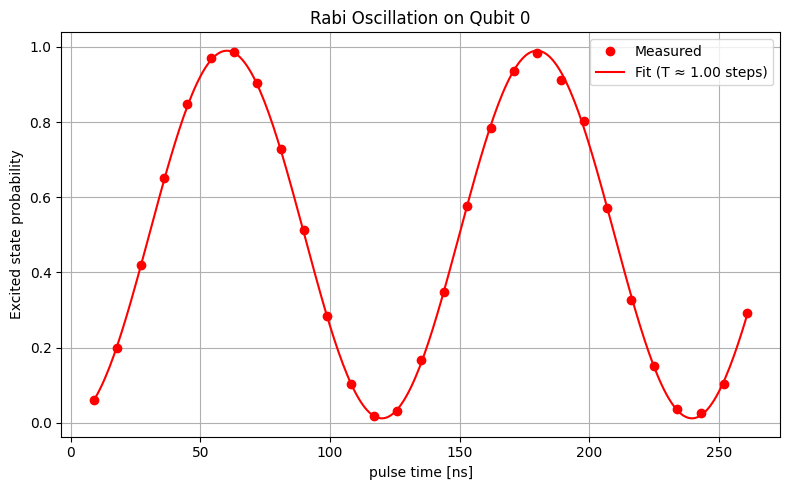

Rabi period Error (vs. calibration)=  0.3294173470944739 %


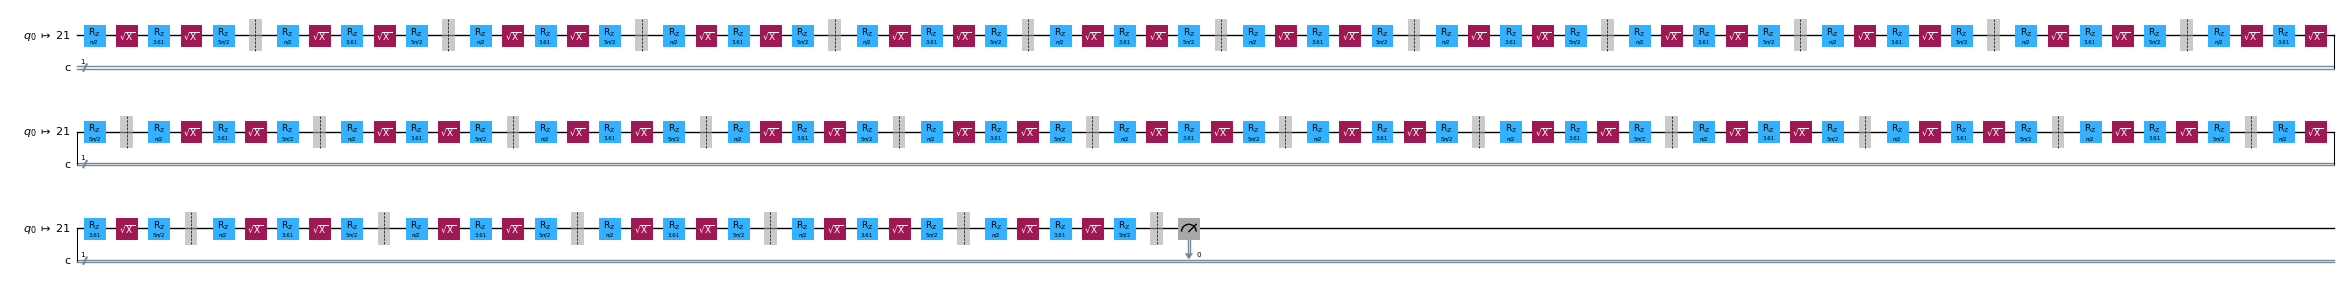

In [50]:
# Sinusoidal model for Rabi oscillation
def rabi_model(t, A, omega, phi, B):
    return A * np.cos(omega * t + phi) + B

# Fit to cosine model
try:
    popt, _ = curve_fit(rabi_model, theta_steps, probs, p0=[0.5, 1.0000, 0, 0.5])
    A, omega, phi, B = popt
    rabi_period = 1 / omega
except RuntimeError:
    rabi_period = None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.array(theta_steps)/(pi)*x_time_ns, probs, 'or', label='Measured')
if rabi_period:
    t_fit = np.linspace(min(theta_steps), max(theta_steps), 300)
    plt.plot(t_fit/(pi)*x_time_ns, rabi_model(t_fit, *popt), '-r',label=f"Fit (T ≈ {rabi_period:.2f} steps)")

plt.xlabel("pulse time [ns]")
plt.ylabel("Excited state probability")
plt.title(f"Rabi Oscillation on Qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print('Rabi period Error (vs. calibration)= ', abs(rabi_period-1)*100 ,'%')

transpiled.draw('mpl', idle_wires=False,scale=0.5, fold=70)

In [ ]:
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

reps = 15
theta = np.pi  # Small angle per step
steps = list(range(1, reps))  # Number of rotations
theta_steps = [reps*theta for reps in steps]

# Run experiments
probs = []
shots=1000

for reps in steps:
    print(reps*theta/(pi))
    qc = rabi_circuit(reps, theta, qubit, num_qubits)
    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.499999999999999
6.0
6.500000000000001
7.0


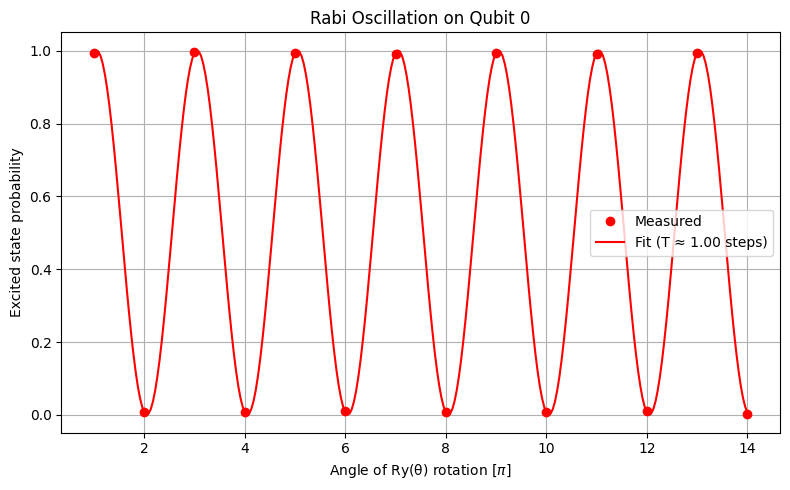

Rabi period Error (vs. calibration)=  0.013134232570255477 %


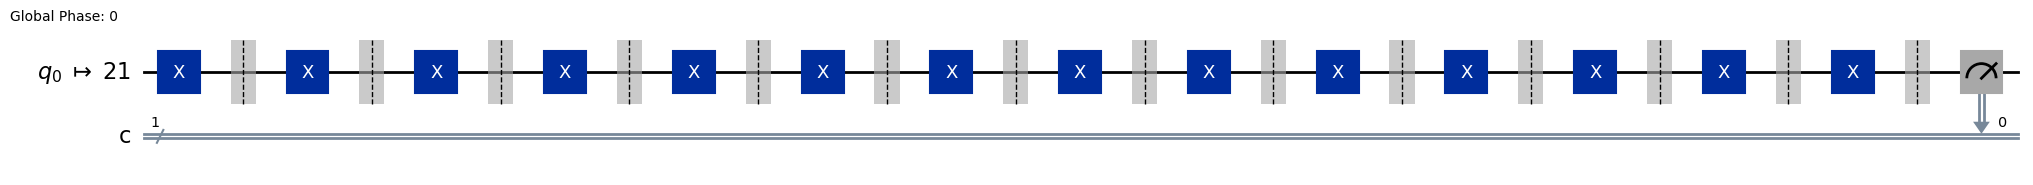

In [56]:
# Sinusoidal model for Rabi oscillation
def rabi_model(t, A, omega, phi, B):
    return A * np.cos(omega * t + phi) + B

# Fit to cosine model
try:
    popt, _ = curve_fit(rabi_model, theta_steps, probs, p0=[0.5, 1.0000, 0, 0.5], bounds=([0.49, 0.95, -np.pi, 0], [0.50, 1.05, np.pi, 0.55]))
    A, omega, phi, B = popt
    rabi_period = 1 / omega
except RuntimeError:
    rabi_period = None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.array(theta_steps)/(pi), probs, 'or', label='Measured')
if rabi_period:
    t_fit = np.linspace(min(theta_steps), max(theta_steps), 300)
    plt.plot(t_fit/(pi), rabi_model(t_fit, *popt), '-r',label=f"Fit (T ≈ {rabi_period:.2f} steps)")

plt.xlabel(r'Angle of Ry(θ) rotation [$\pi$]')
plt.ylabel("Excited state probability")
plt.title(f"Rabi Oscillation on Qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print('Rabi period Error (vs. calibration)= ', abs(rabi_period-1)*100 ,'%')


display(transpiled.draw('mpl', idle_wires=False,fold=reps*2+1))

# Gate Benchmarking

Adding many gates in sequence can calibrate their fidelity

In [718]:
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

n_gates = 500
skip = 50

shots = 1000
probs = []

# Run experiments
for gates in list(range(0, n_gates, skip)):  # Skip specified number of circuits
    print(gates)
    qc = QuantumCircuit(num_qubits)
    for _ in range(gates):
        qc.x(qubit)
        qc.barrier()
        qc.x(qubit)
        qc.barrier()

    qc.x(qubit)
    qc.barrier()
    qc.measure_all()

    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)

0
50
100
150
200
250
300
350
400
450


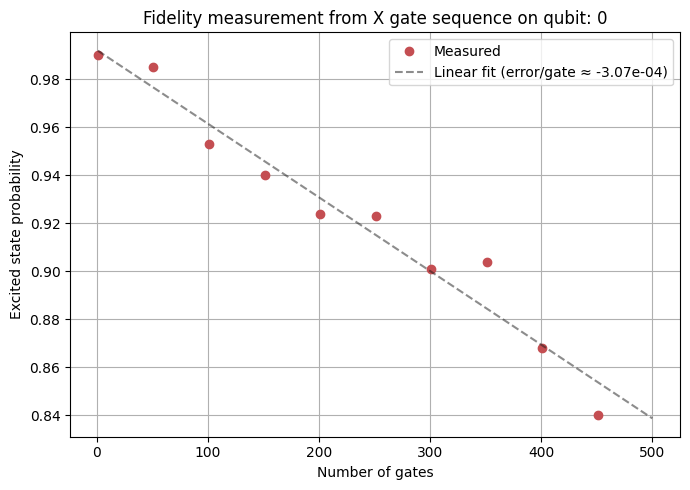

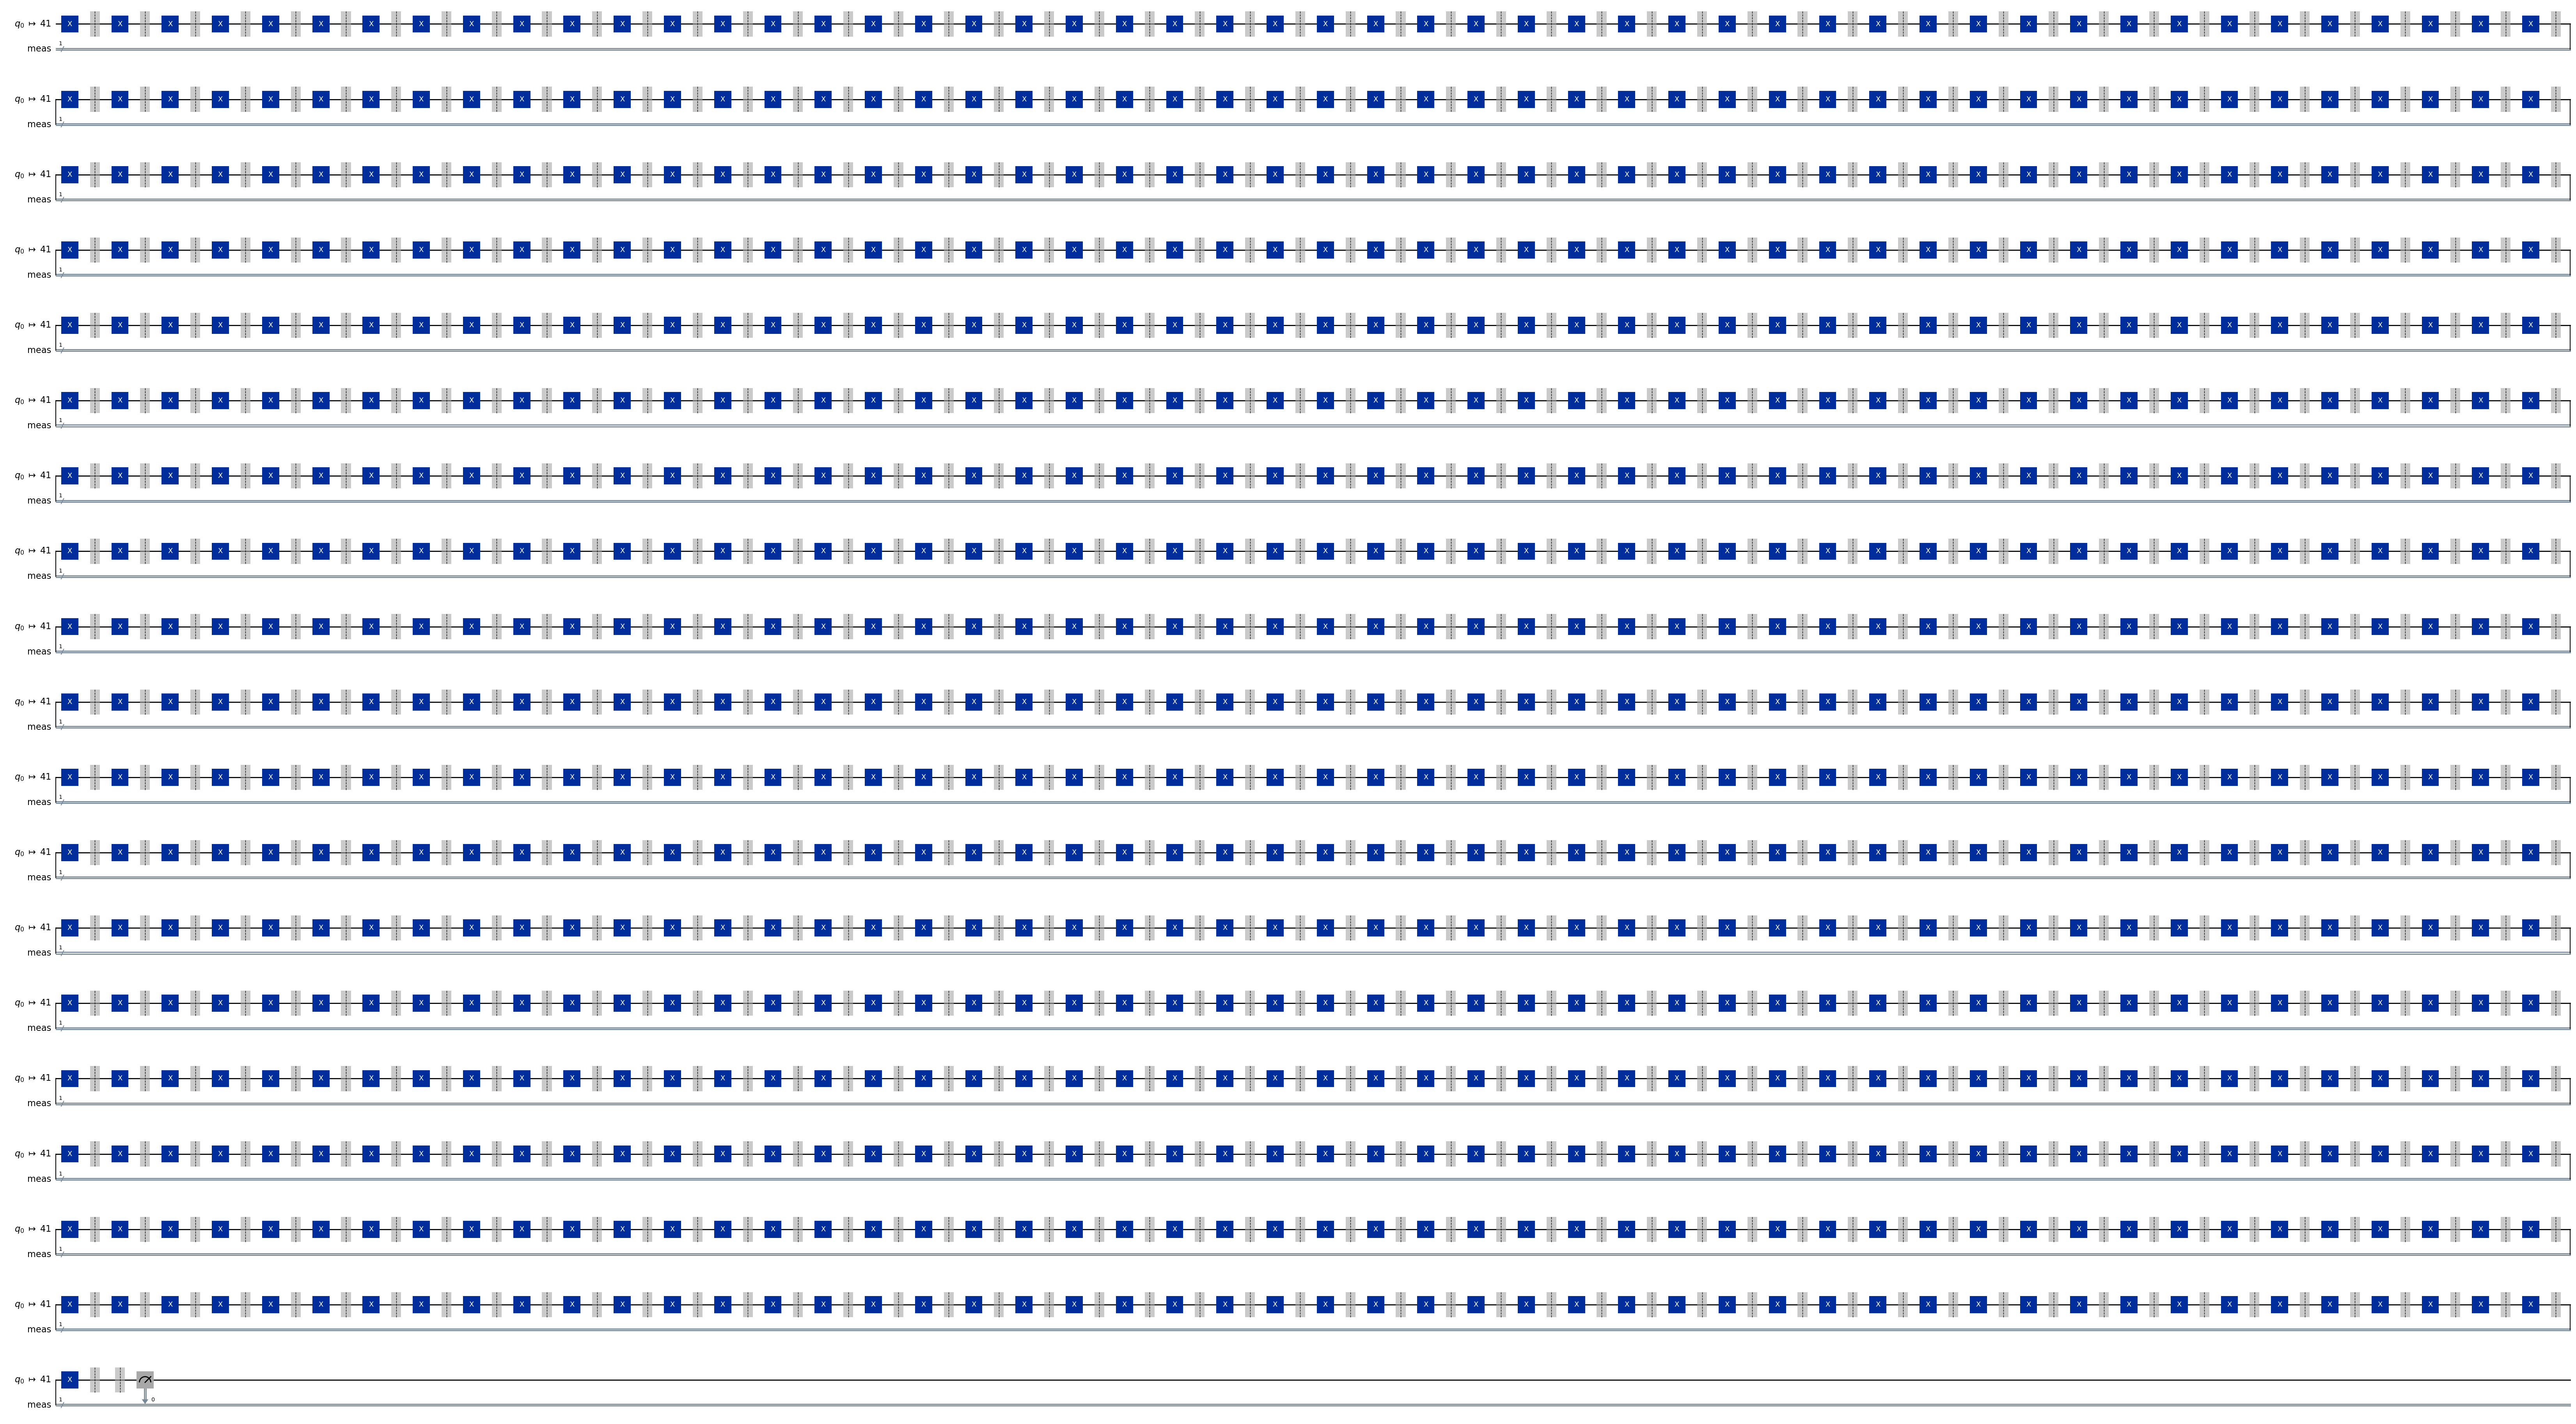

In [742]:
# Linear model
def line(t, m, b):
    return m*t + b

# Fit linear model
try:
    popt, _ = curve_fit(line, list(range(1, n_gates, skip)), np.array(probs))
    m, b = popt
except RuntimeError:
    m, b = None, None

# Plot
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, n_gates, skip)), np.array(probs), 'or', label='Measured')
if m is not None:
    t_fit = np.linspace(1, n_gates, n_gates*2)
    plt.plot(t_fit, line(t_fit, *popt), '--k',
             alpha=0.5, label=f'Linear fit (error/gate ≈ {m:.2e})')

plt.xlabel('Number of gates')
plt.ylabel("Excited state probability") 
plt.title(f"Fidelity measurement from X gate sequence on qubit: {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

display(transpiled.draw('mpl', idle_wires=False,fold=100))

# Randomized Gate Benchmarking

In [682]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.circuit.library import RXGate, RYGate, RZGate, IGate


def random_rotation_gate(angle):
    """Return a random rotation gate (X, Y, Z, or I) with the given angle."""
    gate_type = random.choice(['x', 'y', 'z', 'i'])
    if gate_type == 'x':
        return RXGate(angle)
    elif gate_type == 'y':
        return RYGate(angle)
    elif gate_type == 'z':
        return RZGate(angle)
    else:
        return IGate()

def randomized_benchmarking_circuit(reps, qubit=0, num_qubits=1, target_final_state='1'):
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc_to_inv = QuantumCircuit(num_qubits, num_qubits)

    for _ in range(reps):
        # Random π gate
        gate_pi = random_rotation_gate(np.pi)
        qc.append(gate_pi, [qubit])
        qc_to_inv.append(gate_pi, [qubit])

        # Random π/2 gate
        gate_pio2 = random_rotation_gate(np.pi/2)
        qc.append(gate_pio2, [qubit])
        qc.barrier()
        qc_to_inv.append(gate_pio2, [qubit])

    '''
    Invert the initial gate sequence
    Then use the transpiler to simplify it and add it back to the original circuit
    '''
    qc_inv = qc_to_inv.inverse()
    qc_inv_transpiled = transpile(qc_inv, backend,initial_layout=[0])
    qc_transpiled = transpile(qc, backend,initial_layout=[0])

    # display(qc_inv_transpiled.draw(output='mpl',idle_wires=False))
    # display(qc_transpiled.draw(output='mpl',idle_wires=False))
    qc_transpiled.barrier()
    qc_transpiled.compose(qc_inv_transpiled,inplace=True)
    qc_transpiled.barrier()

    # Flip to |1⟩ 
    if target_final_state == '1':
        qc_transpiled.x(qubit)
        qc_transpiled.barrier()

    qc_transpiled.measure(qubit, qubit)
    return qc_transpiled


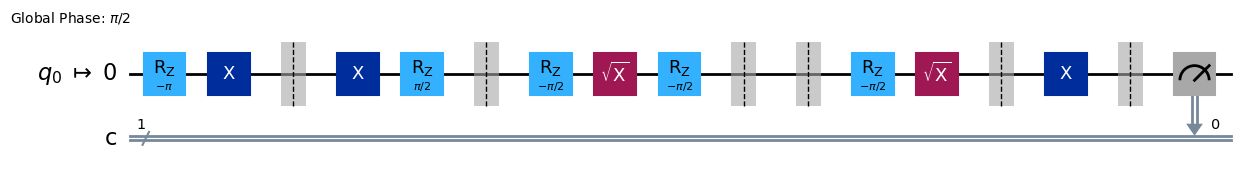

In [684]:
rbc = randomized_benchmarking_circuit(3, qubit=0, num_qubits=1)
rbc.draw('mpl',idle_wires=False)

In [ ]:
# Setup
backend = FakeBrisbane()
num_qubits = 1
qubit = 0

n_gates = 1000
skip = 100

shots = 1000
probs = []

# Run experiments
for gates in list(range(0, n_gates, skip)):  # Skip specified number of circuits
    print(gates)
    
    rbc = randomized_benchmarking_circuit(gates, qubit=0, num_qubits=1)

    transpiled = transpile(rbc, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    probs.append(counts['1']/shots)


0
100
200
300
400
500
600
700
800
900


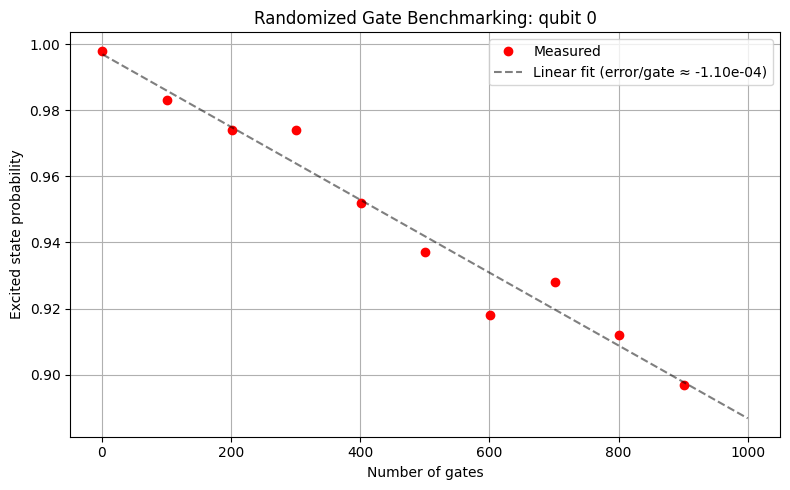

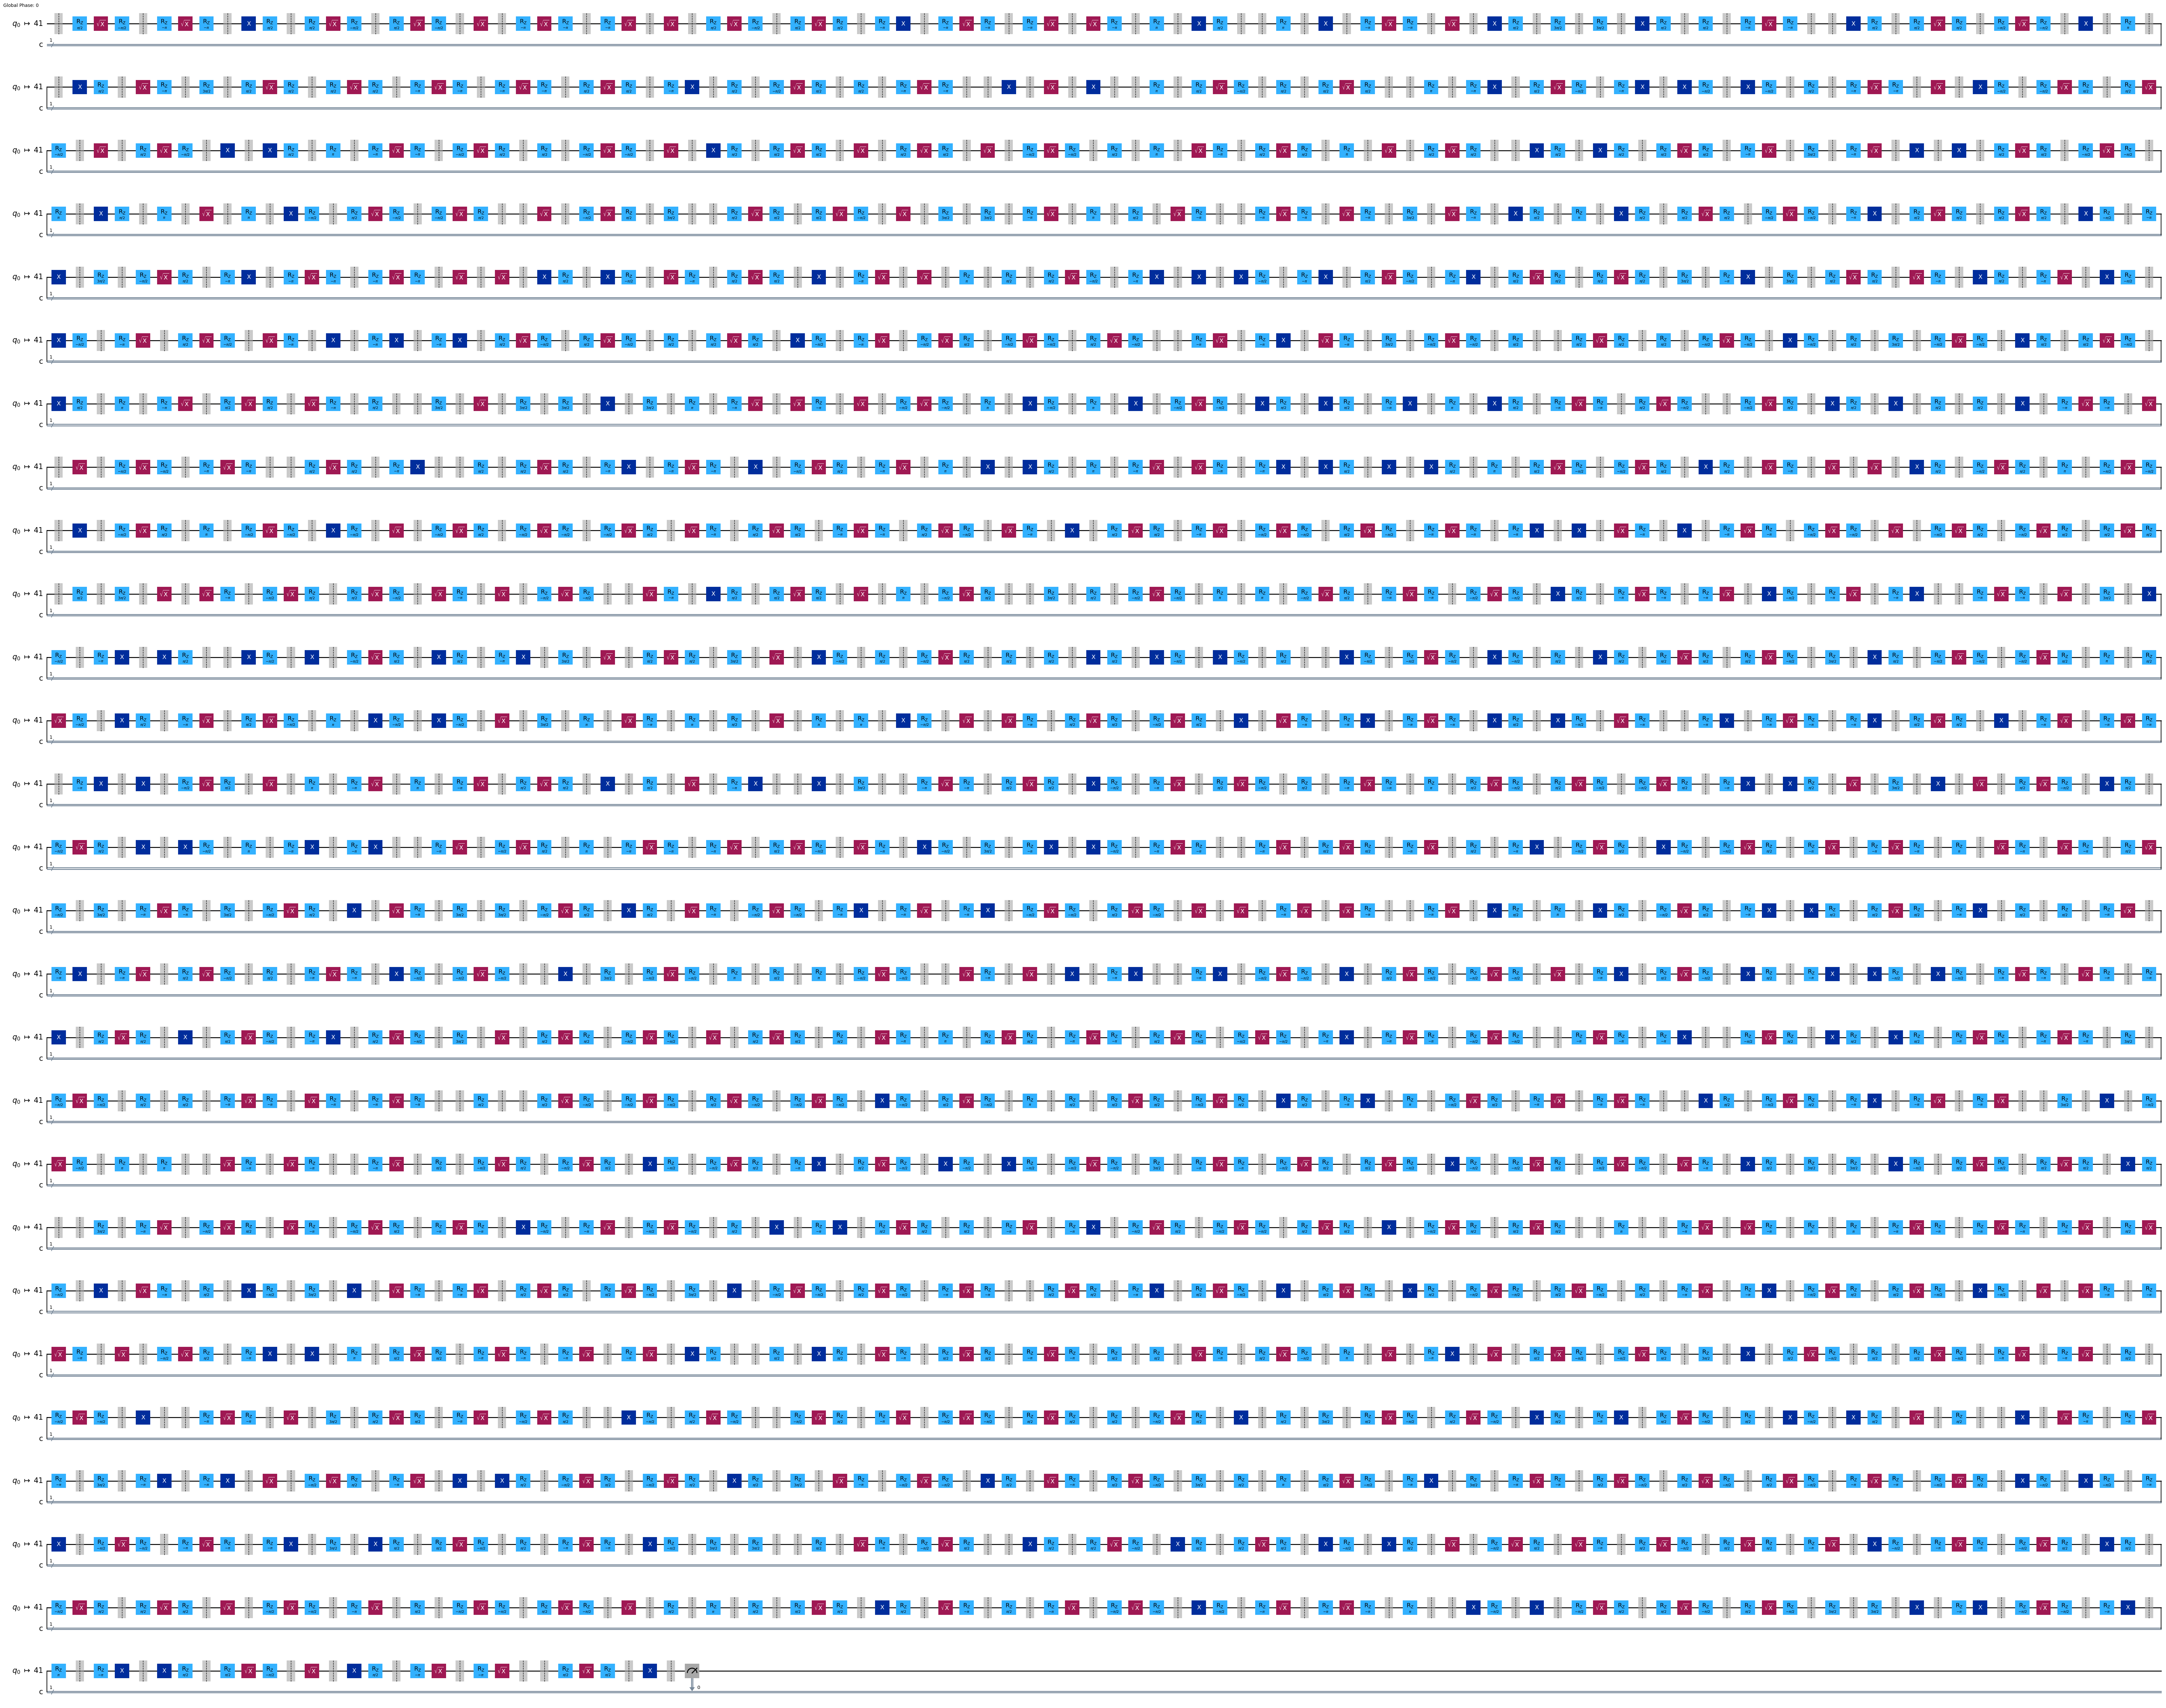

In [ ]:
def line(t, m, b):
    return m*t + b

try:
    popt, _ = curve_fit(line, list(range(1, n_gates, skip)), np.array(probs))
    m, b = popt
except RuntimeError:
    m, b = None, None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, n_gates, skip)), np.array(probs), 'or', label='Measured')
if m is not None:
    t_fit = np.linspace(1, n_gates, n_gates*2)
    plt.plot(t_fit, line(t_fit, *popt), '--k',
             alpha=0.5, label=f'Linear fit (error/gate ≈ {m:.2e})')

plt.xlabel('Number of gate pairs')
plt.ylabel("Excited state probability") 
plt.title(f"Randomized Gate Benchmarking: qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

display(transpiled.draw('mpl', idle_wires=False,fold=100))

# GHZ states - Greenberger–Horne–Zeilinger (GHZ) states

In [34]:

def create_ghz_circuit(num_qubits, phi):
    """
    Creates a GHZ state circuit with parity rotation around Z-axis
    for parity oscillation measurement.
    
    Args:
        num_qubits (int): Number of qubits for GHZ state.
        phi (float): Phase rotation angle to apply to each qubit.
        
    Returns:
        QuantumCircuit: GHZ state with Rz(phi) gates applied.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    # GHZ state preparation
    qc.h(0)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        
    qc.barrier()

    # Global rotation to induce parity oscillations
    for i in range(num_qubits):
        qc.u(pi/2 ,phi,-phi,i)



    qc.barrier()

    # Measurement
    qc.measure(range(num_qubits), range(num_qubits))

    return qc



## GHZ circuit with the final analysis pulse

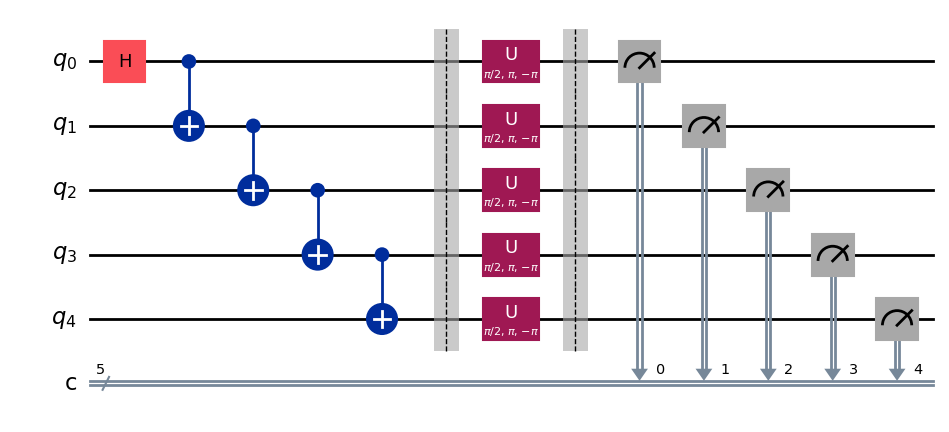

In [35]:

qc = create_ghz_circuit(5, pi)

qc.draw('mpl')

In [36]:
def parity_probabilities(counts):
    """     Return even and odd parity probabilities from measurement counts.     """
    even = 0
    odd = 0
    total = 0

    for bitstring, count in counts.items():
        total += count
        if bitstring.count('1') % 2 == 0:
            even += count
        else:
            odd += count

    p_even = even / total
    p_odd = odd / total
    return p_even, p_odd


In [37]:
def run_parity_oscillations(num_qubits=3, num_shots=1024, num_points=30):
    """
    Sweep over phi values and measure parity using FakeBrisbane.
    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, 2 * np.pi, num_points)
    p_even_vals = []
    p_odd_vals = []

    for phi in phi_vals:
        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    return phi_vals, p_even_vals, p_odd_vals

In [ ]:
phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=5, num_shots=1024, num_points=30)


In [41]:
def plot_parity_probabilities(phi_vals, p_even_vals, p_odd_vals, fs=14, title="GHZ Parity Oscillations"):
    """
    Plots the even and odd parity probabilities vs. rotation angle.

    Args:
        phi_vals (list or np.ndarray): Rotation angles (in radians).
        p_even_vals (list): Even parity probabilities.
        p_odd_vals (list): Odd parity probabilities.
        fs (int, optional): Font size for labels. Default is 14.
        title (str, optional): Plot title.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(phi_vals, p_even_vals, 'o-r', label='Even')
    plt.plot(phi_vals, p_odd_vals, 'o-b', label='Odd')
    plt.xlabel('Axis of analysis pulse [rad]', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

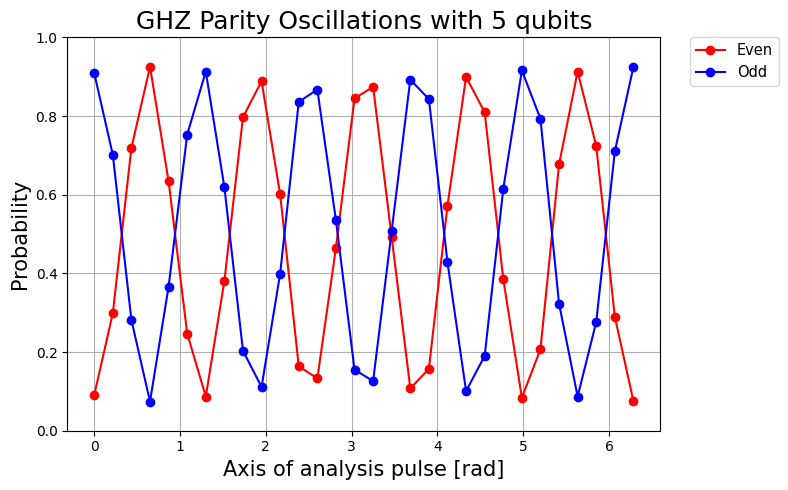

In [42]:
plot_parity_probabilities(phi_vals, p_even_vals, p_odd_vals, fs=15, title="GHZ Parity Oscillations with 5 qubits")

# Parity Contrast fit

To measure the fidelity we need to measure the contrast of the Parity oscillations

In [43]:
def _cosn_model(theta, A, theta0, B, n):
    """Cosine model with n oscillations."""
    return A * np.cos(n * theta + theta0) + B

def plot_parity_vs_theta_with_fit(theta_vals, p_even_vals, p_odd_vals, n_qubits, fs=14, title="GHZ Parity vs Axis Angle"):
    """
    Plots parity vs axis angle theta, fits even parity to extract contrast for n-qubit GHZ.

    Args:
        theta_vals (array): Rotation axis angles (radians).
        p_even_vals (array): Even parity probabilities.
        p_odd_vals (array): Odd parity probabilities.
        n_qubits (int): Number of qubits in the GHZ state.
        fs (int): Font size.
        title (str): Plot title.

    Returns:
        float: Extracted contrast.
    """
    theta_vals = np.array(theta_vals)
    p_even_vals = np.array(p_even_vals)

    # Fit to model: A * cos(n * θ + θ₀) + B
    def fit_func(theta, A, theta0, B):
        return _cosn_model(theta, A, theta0, B, n_qubits)

    p0 = [0.5, 0, 0.5]  # Initial guess: amplitude, phase offset, baseline
    popt, _ = curve_fit(fit_func, theta_vals, p_even_vals, p0=p0)
    A_fit, theta0_fit, B_fit = popt
    contrast = 2 * abs(A_fit)

    # Smooth curve for fit
    theta_smooth = np.linspace(min(theta_vals), max(theta_vals), 1000)
    fit_smooth = fit_func(theta_smooth, *popt)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_smooth, fit_smooth, '-r', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_smooth, 1-fit_smooth, '-b', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_vals, p_even_vals, 'or', label='Even (data)')
    plt.plot(theta_vals, p_odd_vals, 'ob', label='Odd (data)')
    plt.xlabel('Axis angle θ (rad)', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

    return contrast


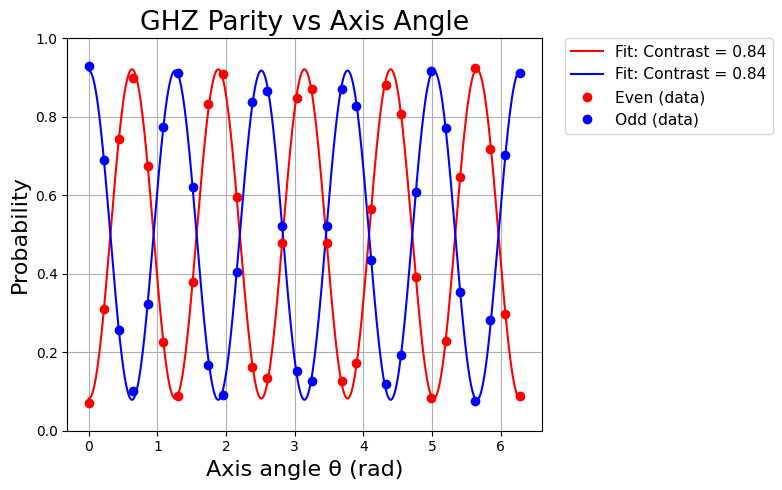

Extracted contrast: 0.839


In [182]:
num_qubits = 5

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=num_qubits*6)

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


## GHZ state of 10 qubits? Will take a minute to simulate...

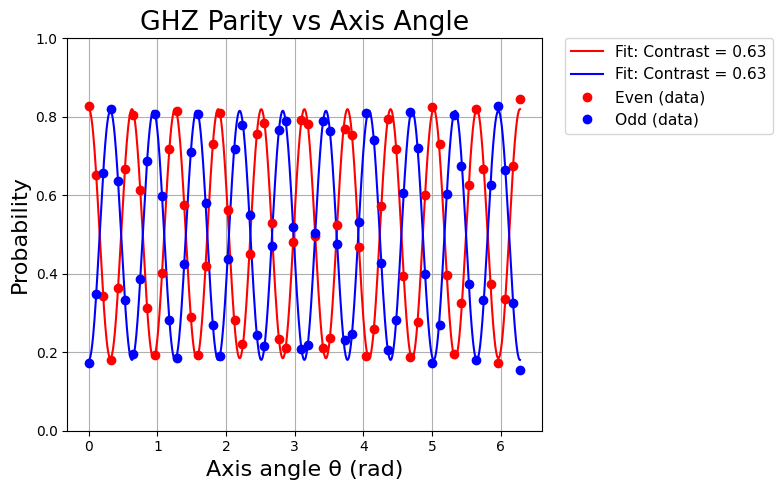

Extracted contrast: 0.635


In [183]:
num_qubits = 10

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=num_qubits*6)

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


## Parity oscillations of 15 qubit GHZ state? 

Would take a long time to simulate all of the angles of rotation...

Let's only scan over two fringes of the Parity oscillation instead to save time.

In [44]:
def run_parity_oscillations(num_qubits=3, num_shots=1024, num_points=30, phi_max=2*np.pi):
    """
    Sweep over phi values from 0 to phi_max and measure parity using FakeBrisbane.

    Args:
        num_qubits (int): Number of qubits in the GHZ state.
        num_shots (int): Number of measurement shots per circuit.
        num_points (int): Number of phi values to sweep.
        phi_max (float): Final value of phi in the sweep (default: 2π).

    Returns:
        tuple: (phi_vals, p_even_vals, p_odd_vals)
    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, phi_max, num_points)
    p_even_vals = []
    p_odd_vals = []

    for phi in phi_vals:
        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    return phi_vals, p_even_vals, p_odd_vals


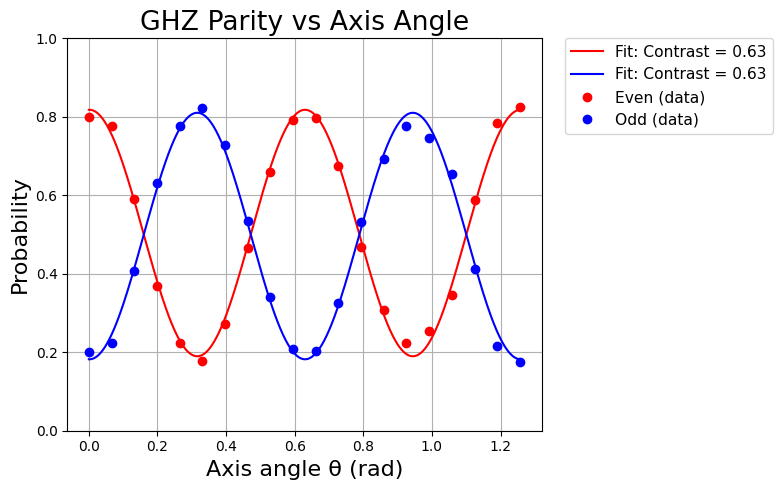

Extracted contrast: 0.628


In [195]:
num_qubits = 10

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=20, phi_max=2*np.pi/(num_qubits/2))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


# 15 qubit GHZ state parity oscillations!

simulated in only a few minutes!

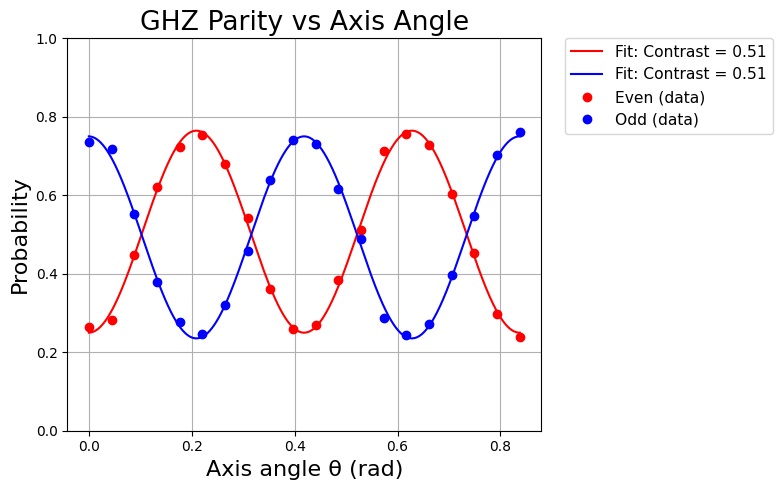

Extracted contrast: 0.515


In [196]:
num_qubits = 15

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=10, phi_max=2*np.pi/(num_qubits/2))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

This will take almost a few minutes to run:

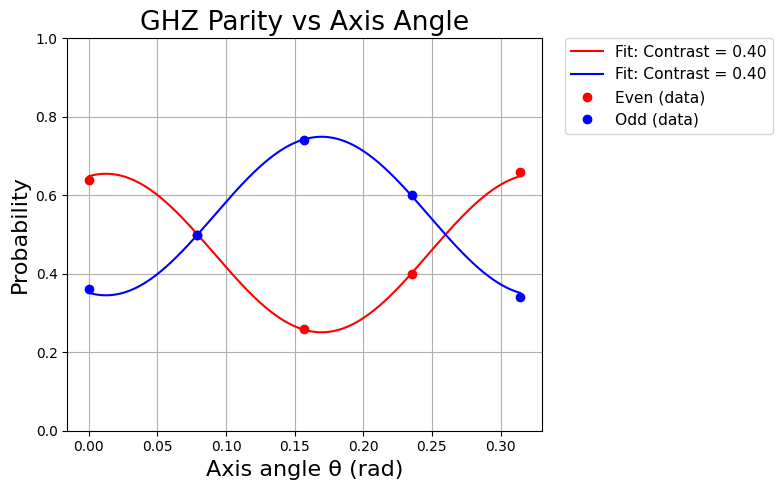

Extracted contrast: 0.404


In [ ]:
num_qubits = 20

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=7, phi_max=2*np.pi/(num_qubits))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

# GHZ parity contrast decay vs. number of qubits

Compiling these contrasts together we can now extract the decay of the GHZ state fidelity vs. number of qubits

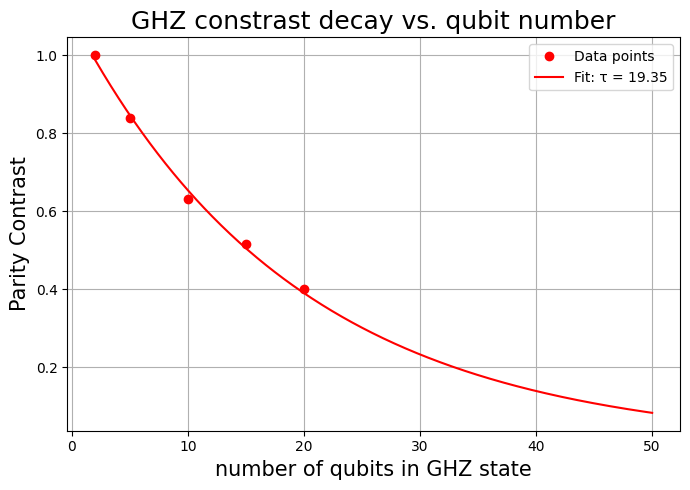

In [47]:
# Parity Constrast Data
x_vals = np.array([2, 5, 10, 15, 20])
y_vals = np.array([1.0, 0.839, 0.630, 0.515, 0.4])

# Exponential decay model
def decay_model(x, A, tau):
    return A * np.exp(-x / tau)

# Initial guess: A, tau, C
p0 = [1.0, 5.0]

# Fit the curve
popt, _ = curve_fit(decay_model, x_vals, y_vals, p0=p0)
A_fit, tau_fit = popt

# Smooth curve for plotting
x_smooth = np.linspace(2, 50, 500)
y_smooth = decay_model(x_smooth, *popt)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(x_vals, y_vals, 'or', label='Data points')
plt.plot(x_smooth, y_smooth, '-r',  label=f'Fit: τ = {tau_fit:.2f}')
plt.xlabel('number of qubits in GHZ state', fontsize =fs)
plt.ylabel('Parity Contrast', fontsize =fs)
plt.title('GHZ constrast decay vs. qubit number', fontsize =fs*1.2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Quantum Volume

In [141]:
from qiskit.circuit.library import QuantumVolume

def create_quantum_volume_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits, num_qubits)

    qv = QuantumVolume(num_qubits, depth)
    qc.compose(qv, inplace=True)

    qc.barrier()
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

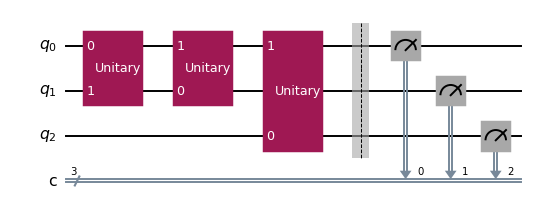

In [142]:
num_qubits=3
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)

qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

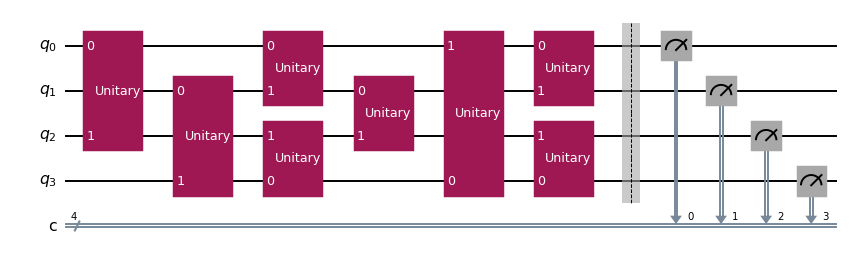

In [143]:
num_qubits=4
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)

qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

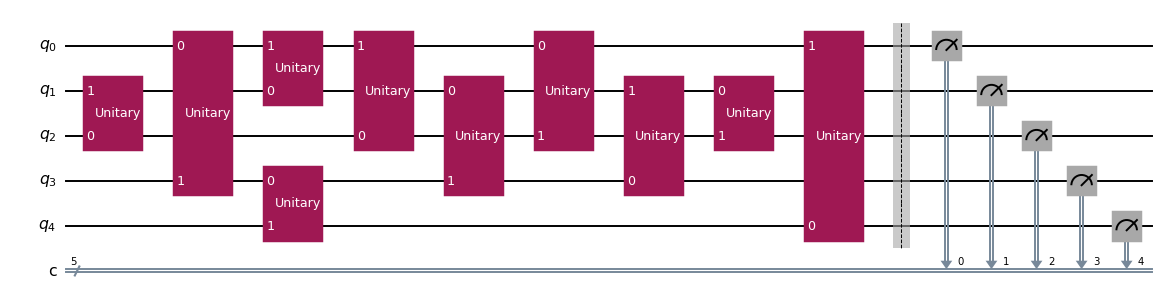

In [144]:
num_qubits=5
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)

qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

# Simulate the QV on fake_brisbane

In [145]:
transpiled_circuit = transpile(qv_circuit, backend)

job = backend.run(transpiled_circuit, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)

{'01110': 58, '00110': 26, '01011': 126, '00010': 15, '10011': 22, '01001': 19, '10001': 20, '00100': 57, '11011': 32, '01100': 64, '00011': 50, '11111': 10, '01010': 18, '00111': 51, '00001': 43, '11101': 59, '11010': 23, '01111': 35, '00000': 12, '10100': 20, '11000': 21, '10110': 19, '10101': 32, '00101': 19, '01101': 51, '01000': 23, '11110': 7, '10111': 33, '11001': 12, '10010': 10, '11100': 13}


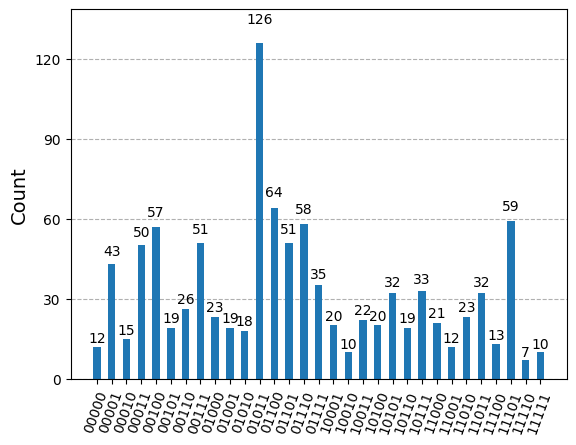

In [146]:
plot_histogram(counts)

In [151]:
from qiskit.quantum_info import Statevector

def get_ideal_qv_distribution(circuit):
    """
    Simulates the ideal output probability distribution of a QV circuit.
    """
    # Remove measurements for pure statevector simulation
    qc = circuit.remove_final_measurements(inplace=False)

    # Simulate the statevector
    state = Statevector.from_instruction(qc)

    # Get probabilities of measuring each computational basis state
    probs = state.probabilities_dict()

    # Sort keys for consistency
    sorted_probs = {k: probs[k] for k in sorted(probs.keys())}
    return sorted_probs


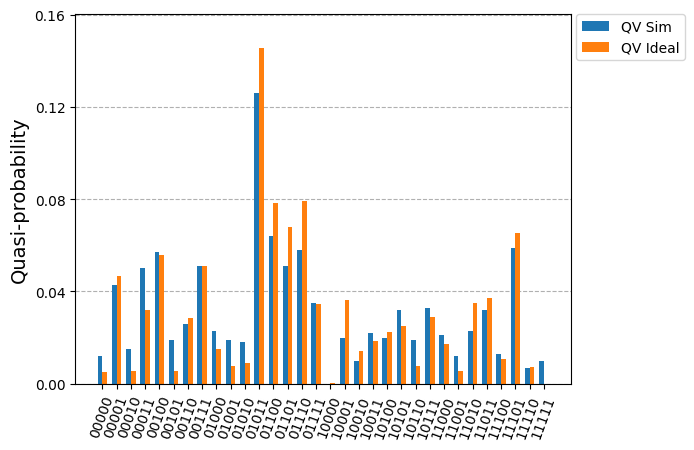

In [155]:
ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)


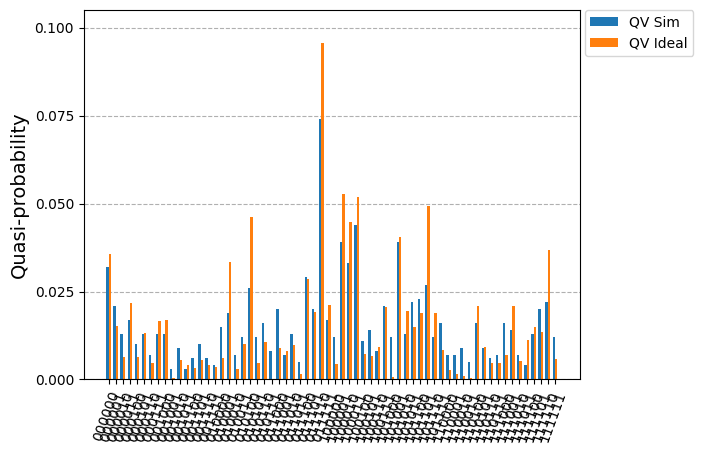

In [174]:
num_qubits=6

qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)


# Heavy output

## 1. Find median of ideal probabilities

In [175]:
probs = list(ideal_probs.values())
median = np.median(probs)
print('median of ideal probabilities = ',median)

median of ideal probabilities =  0.009176015419986822


## 2. Identify heavy output bitstrings

In [198]:

heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
print(heavy_outputs)

{np.str_('011010'), np.str_('000101'), np.str_('111101'), np.str_('011101'), np.str_('101101'), np.str_('010011'), np.str_('000001'), np.str_('101010'), np.str_('101011'), np.str_('111001'), np.str_('001000'), np.str_('011111'), np.str_('100111'), np.str_('101100'), np.str_('000111'), np.str_('111110'), np.str_('100010'), np.str_('011110'), np.str_('010110'), np.str_('000011'), np.str_('100011'), np.str_('101110'), np.str_('000000'), np.str_('011100'), np.str_('111011'), np.str_('100110'), np.str_('100001'), np.str_('110100'), np.str_('101001'), np.str_('010001'), np.str_('111100'), np.str_('010100')}


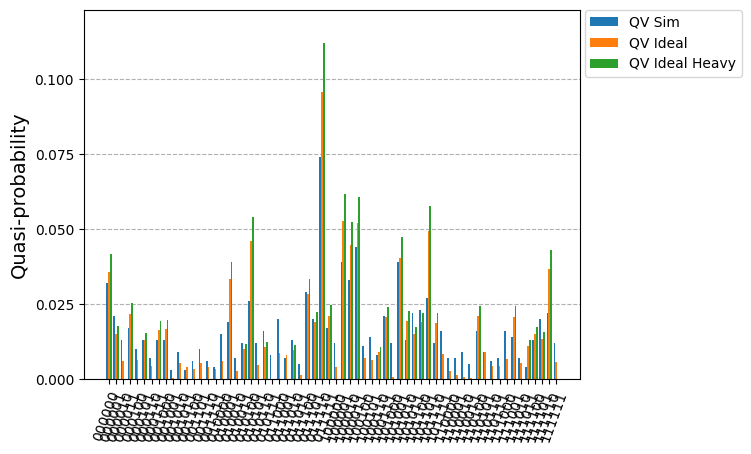

In [215]:
heavy_ideal_probs = {bit: prob for bit, prob in ideal_probs.items() if prob > median}

plot_histogram([counts, ideal_probs,heavy_ideal_probs], legend=("QV Sim", "QV Ideal", "QV Ideal Heavy") , bar_labels=False)

## 3. Sum up counts of heavy outputs

In [221]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

heavy_probs = sum(ideal_probs.get(bit, 0) for bit in heavy_outputs);

print(heavy_probs)

0.8544034631839427


In [222]:
def compute_heavy_output_prob(ideal_probs, measured_counts):
    # 1. Find median of ideal probabilities
    probs = list(ideal_probs.values())
    median = np.median(probs)

    # 2. Identify heavy output bitstrings
    heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}

    # 3. Sum up counts of heavy outputs 
    heavy_counts = sum(measured_counts.get(bit, 0) for bit in heavy_outputs)

    return heavy_counts / shots


In [223]:
# Compute heavy output probability
hop = compute_heavy_output_prob(ideal_probs, counts)
print(f"Heavy Output Probability: {hop:.4f}")


Heavy Output Probability: 0.7050


Median probability of counts in QV circuit outputs =  0.031971921879173956
Heavy Output Probability= 87.5 %  is over 67% --> Success!)


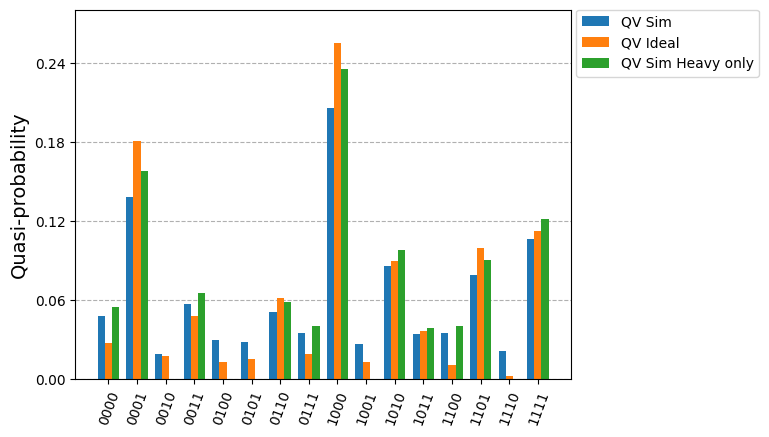

In [263]:
num_qubits=4

'''Create QV circuit'''
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

'''Simulate QV circuit'''
shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

'''Calculate ideal QV outputs'''
ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)

'''
QV analysis of Heavy outputs
'''
probs = list(ideal_probs.values())
median = np.median(probs)
print('Median probability of counts in QV circuit outputs = ',median)
heavy_outputs = {bit for bit, count in counts.items() if count > median*shots}
heavy_count_probs = {bit: count/shots for bit, count in counts.items() if count > median*shots}

heavy_probs = sum(counts.get(bit, 0) for bit in heavy_outputs);

heavy_output_probability = heavy_probs/shots*100

if heavy_output_probability > 2/3/100:
    print('Heavy Output Probability=',heavy_output_probability,'%  is over 67% --> Success!)')
else:
    print('Heavy Output Probability=',heavy_output_probability,'%  is under 67% --> try again..)')

plot_histogram([counts, ideal_probs,heavy_count_probs], legend=("QV Sim", "QV Ideal", "QV Sim Heavy only") , bar_labels=False)

Median probability of counts in QV circuit outputs =  0.020210756813825125
Heavy Output Probability= 83.7 %  is over 67% --> Success!)


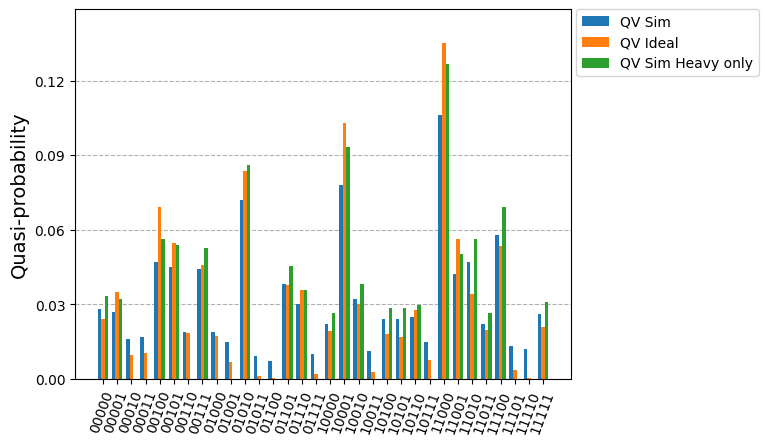

In [262]:
num_qubits=5

'''Create QV circuit'''
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

'''Simulate QV circuit'''
shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

'''Calculate ideal QV outputs'''
ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)

'''
QV analysis of Heavy outputs
'''
probs = list(ideal_probs.values())
median = np.median(probs)
print('Median probability of counts in QV circuit outputs = ',median)
heavy_outputs = {bit for bit, count in counts.items() if count > median*shots}
heavy_count_probs = {bit: count/shots for bit, count in counts.items() if count > median*shots}

heavy_probs = sum(counts.get(bit, 0) for bit in heavy_outputs);

heavy_output_probability = heavy_probs/shots*100

if heavy_output_probability > 2/3/100:
    print('Heavy Output Probability=',heavy_output_probability,'%  is over 67% --> Success!)')
else:
    print('Heavy Output Probability=',heavy_output_probability,'%  is under 67% --> try again..)')

plot_histogram([counts, ideal_probs,heavy_count_probs], legend=("QV Sim", "QV Ideal", "QV Sim Heavy only") , bar_labels=False)


In [261]:
num_qubits=8

'''Create QV circuit'''
qv_circuit = create_quantum_volume_circuit(num_qubits=num_qubits, depth=num_qubits)
qv_circuit.decompose().draw('mpl', fold = 50, scale = 0.7)

'''Simulate QV circuit'''
shots = 1000
transpiled_circuit = transpile(qv_circuit, backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

'''Calculate ideal QV outputs'''
ideal_probs = get_ideal_qv_distribution(qv_circuit)

plot_histogram([counts, ideal_probs], legend=("QV Sim", "QV Ideal") , bar_labels=False)

'''
QV analysis of Heavy outputs
'''
probs = list(ideal_probs.values())
median = np.median(probs)
print('Median probability of counts in QV circuit outputs = ',median)
heavy_outputs = {bit for bit, count in counts.items() if count > median*shots}
heavy_count_probs = {bit: count/shots for bit, count in counts.items() if count > median*shots}

heavy_probs = sum(counts.get(bit, 0) for bit in heavy_outputs);

heavy_output_probability = heavy_probs/shots*100

if heavy_output_probability > 2/3/100:
    print('Heavy Output Probability=',heavy_output_probability,'%  is over 67% --> Success!)')
else:
    print('Heavy Output Probability=',heavy_output_probability,'%  is under 67% --> try again..)')


# plot_histogram([counts, ideal_probs,heavy_count_probs], legend=("QV Sim", "QV Ideal", "QV Sim Heavy only") , bar_labels=False)


Median probability of counts in QV circuit outputs =  0.0025691139075045945
Heavy Output Probability= 88.8 %  is over 67% --> Success!)



--- Running QV for 2 qubits/depth ---
Heavy Output Probability = 0.9400 → ✅ SUCCESS

--- Running QV for 3 qubits/depth ---
Heavy Output Probability = 0.8490 → ✅ SUCCESS

--- Running QV for 4 qubits/depth ---
Heavy Output Probability = 0.8050 → ✅ SUCCESS

--- Running QV for 5 qubits/depth ---
Heavy Output Probability = 0.7990 → ✅ SUCCESS

--- Running QV for 6 qubits/depth ---
Heavy Output Probability = 0.7380 → ✅ SUCCESS

--- Running QV for 7 qubits/depth ---
Heavy Output Probability = 0.6530 → ❌ FAIL

--- Running QV for 8 qubits/depth ---
Heavy Output Probability = 0.5880 → ❌ FAIL

--- Running QV for 9 qubits/depth ---
Heavy Output Probability = 0.5500 → ❌ FAIL

--- Running QV for 10 qubits/depth ---
Heavy Output Probability = 0.5680 → ❌ FAIL


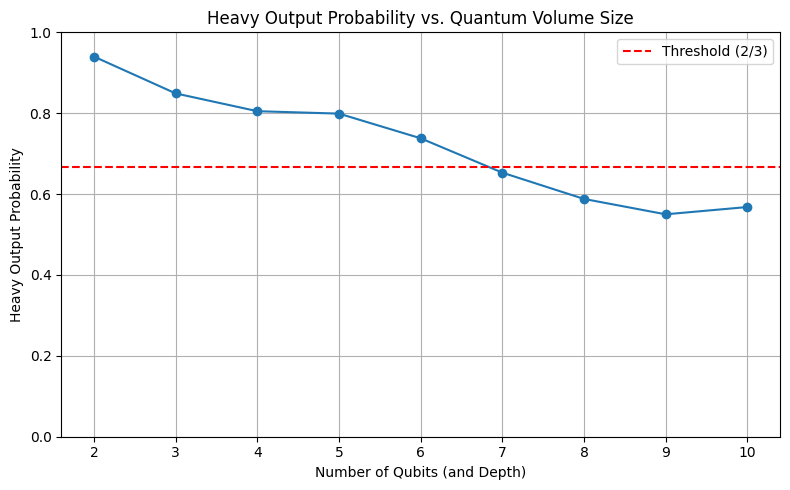

In [269]:
min_qubits=2
max_qubits=10
shots=1000

"""
Runs Quantum Volume analysis across a range of qubit sizes and depths.
Plots the Heavy Output Probability vs number of qubits.

Args:
    min_qubits (int): Starting number of qubits (and depth).
    max_qubits (int): Maximum number of qubits (and depth).
    shots (int): Number of shots per circuit.
"""
heavy_output_probs = []

for n in range(min_qubits, max_qubits + 1):
    print(f"\n--- Running QV for {n} qubits/depth ---")
    
    # Create and simulate QV circuit
    qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)

    '''Simulate QV circuit'''
    transpiled_circuit = transpile(qv_circuit, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Get ideal probabilities
    ideal_probs = get_ideal_qv_distribution(qv_circuit)

    # Compute heavy outputs
    median = np.median(list(ideal_probs.values()))
    heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
    heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs)
    heavy_prob = heavy_counts / shots
    heavy_output_probs.append(heavy_prob)

    status = "✅ SUCCESS" if heavy_prob > 2/3 else "❌ FAIL"
    print(f"Heavy Output Probability = {heavy_prob:.4f} → {status}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(range(min_qubits, max_qubits + 1), heavy_output_probs, marker='o')
plt.axhline(2/3, color='r', linestyle='--', label='Threshold (2/3)')
plt.title("Heavy Output Probability vs. Quantum Volume Size")
plt.xlabel("Number of Qubits (and Depth)")
plt.ylabel("Heavy Output Probability")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [272]:
def run_qv_statistical_analysis(min_qubits=2, max_qubits=8, shots=1000, repeats=10):
    """
    Runs Quantum Volume analysis across a range of qubit sizes and depths,
    repeating multiple random circuits per size to gather statistics.

    Args:
        min_qubits (int): Minimum number of qubits (and depth).
        max_qubits (int): Maximum number of qubits (and depth).
        shots (int): Number of shots per QV circuit.
        repeats (int): Number of random circuits per qubit size.
    """
    avg_heavy_probs = []
    std_heavy_probs = []

    for n in range(min_qubits, max_qubits + 1):
        print(f"\n--- Running QV for {n} qubits/depth ({repeats} trials) ---")
        heavy_probs_n = []

        for rep in range(repeats):
            # Create and simulate QV circuit
            qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)
            transpiled = transpile(qv_circuit, backend)
            result = backend.run(transpiled, shots=shots).result()
            counts = result.get_counts()

            # Ideal distribution
            ideal_probs = get_ideal_qv_distribution(qv_circuit)
            median = np.median(list(ideal_probs.values()))
            heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median}
            heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs)
            heavy_prob = heavy_counts / shots
            heavy_probs_n.append(heavy_prob)

        avg = np.mean(heavy_probs_n)
        std = np.std(heavy_probs_n)
        avg_heavy_probs.append(avg)
        std_heavy_probs.append(std)

        status = "✅ SUCCESS" if avg > 2/3 else "❌ FAIL"
        print(f"Avg Heavy Output Prob = {avg:.4f} ± {std:.4f} → {status}")

    # Plot results with error bars
    qubit_range = range(min_qubits, max_qubits + 1)
    plt.figure(figsize=(8, 5))
    plt.errorbar(qubit_range, avg_heavy_probs, yerr=std_heavy_probs, fmt='o-', capsize=5)
    plt.axhline(2/3, color='r', linestyle='--', label='Threshold (2/3)')
    plt.title(f"Heavy Output Probability vs. Qubit Count (shots={shots}, repeats={repeats})")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Heavy Output Probability")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



--- Running QV for 2 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7740 ± 0.1114 → ✅ SUCCESS

--- Running QV for 3 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.8114 ± 0.0428 → ✅ SUCCESS

--- Running QV for 4 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7807 ± 0.0668 → ✅ SUCCESS

--- Running QV for 5 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7603 ± 0.0361 → ✅ SUCCESS

--- Running QV for 6 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.7145 ± 0.0383 → ✅ SUCCESS

--- Running QV for 7 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.6694 ± 0.0200 → ✅ SUCCESS

--- Running QV for 8 qubits/depth (10 trials) ---
Avg Heavy Output Prob = 0.6189 ± 0.0307 → ❌ FAIL


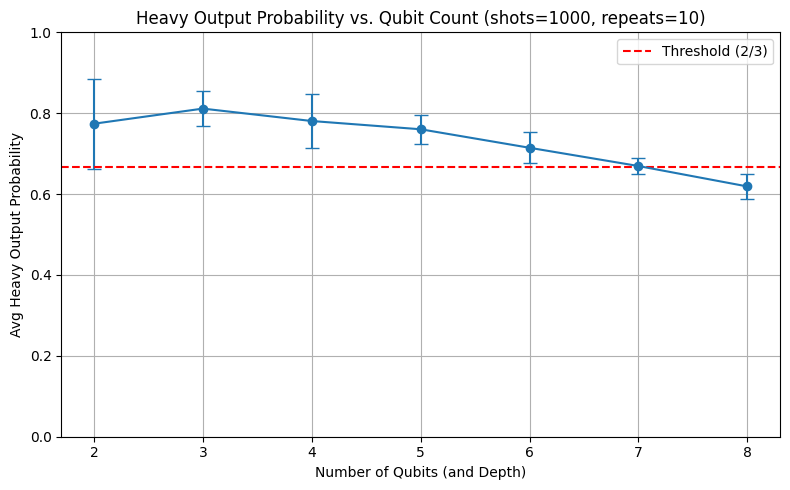

In [273]:
run_qv_statistical_analysis(min_qubits=2, max_qubits=8, shots=1000, repeats=10)

In [274]:
print(2**7)

128


## Quantum volume of about $2^7$ = 128! Not bad!

In [288]:
import time

def measure_qv_simulation_time(min_qubits=2, max_qubits=20, repeats=3):
    """
    Measures classical simulation time (statevector) for QV circuits of increasing size,
    and plots average time with error bars.

    Args:
        min_qubits (int): Minimum number of qubits to test.
        max_qubits (int): Maximum number of qubits to test.
        repeats (int): Number of repetitions to average simulation time.
    """
    sim_times = []
    sim_stds = []
    qubit_range = range(min_qubits, max_qubits + 1)

    for n in qubit_range:
        print(f"\n⏳ Simulating QV circuit with {n} qubits x {n} depth...")

        times = []
        for _ in range(repeats):
            qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)

            start = time.time()
            _ = get_ideal_qv_distribution(qv_circuit)
            elapsed = time.time() - start
            times.append(elapsed)

        avg_time = np.mean(times)
        std_time = np.std(times)

        sim_times.append(avg_time)
        sim_stds.append(std_time)

        print(f"Avg simulation time for {n} qubits: {avg_time:.3f}s ± {std_time:.3f}s")

    # Plot with error bars
    plt.figure(figsize=(8, 5))
    plt.errorbar(list(qubit_range), sim_times, yerr=sim_stds, fmt='o-', capsize=5)
    plt.title("Classical Simulation Time vs. Number of Qubits")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Simulation Time (seconds)")
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()



⏳ Simulating QV circuit with 2 qubits x 2 depth...
Avg simulation time for 2 qubits: 0.002s ± 0.000s

⏳ Simulating QV circuit with 3 qubits x 3 depth...
Avg simulation time for 3 qubits: 0.002s ± 0.000s

⏳ Simulating QV circuit with 4 qubits x 4 depth...
Avg simulation time for 4 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 5 qubits x 5 depth...
Avg simulation time for 5 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 6 qubits x 6 depth...
Avg simulation time for 6 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 7 qubits x 7 depth...
Avg simulation time for 7 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 8 qubits x 8 depth...
Avg simulation time for 8 qubits: 0.006s ± 0.000s

⏳ Simulating QV circuit with 9 qubits x 9 depth...
Avg simulation time for 9 qubits: 0.006s ± 0.000s

⏳ Simulating QV circuit with 10 qubits x 10 depth...
Avg simulation time for 10 qubits: 0.008s ± 0.000s

⏳ Simulating QV circuit with 11 qubits x 11 depth...
Avg simulation time for 1

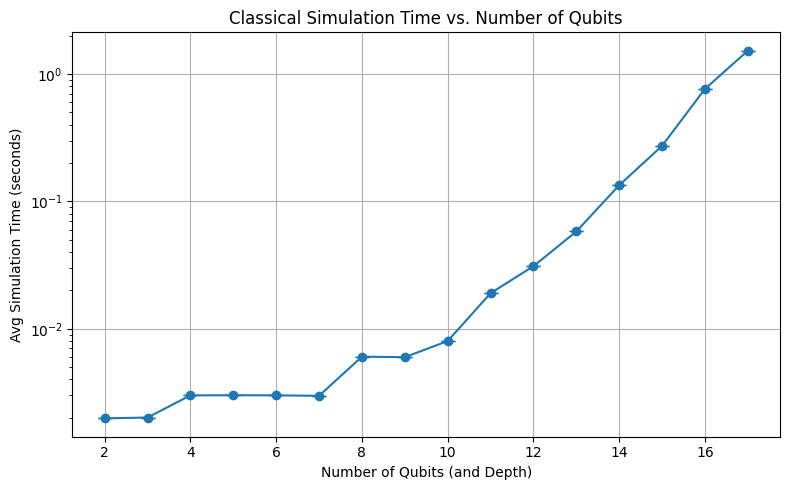

In [293]:
measure_qv_simulation_time(min_qubits=2, max_qubits=17, repeats=1)

In [ ]:
def exponential_model(n, a, b):
    return a * (2 ** (b * n))

def measure_qv_simulation_time(min_qubits=2, max_qubits=20, repeats=3, extrapolate_to=100):
    """
    Measures classical simulation time (statevector) for QV circuits of increasing size,
    and fits an exponential model to extrapolate runtime for large qubit counts.

    Args:
        min_qubits (int): Minimum number of qubits to test.
        max_qubits (int): Maximum number of qubits to test.
        repeats (int): Number of repetitions to average simulation time.
        extrapolate_to (int): Qubit count to extrapolate the runtime.
    """
    sim_times = []
    sim_stds = []
    qubit_range = range(min_qubits, max_qubits + 1)

    for n in qubit_range:
        print(f"\n⏳ Simulating QV circuit with {n} qubits x {n} depth...")

        times = []
        for _ in range(repeats):
            qv_circuit = create_quantum_volume_circuit(num_qubits=n, depth=n)

            start = time.time()
            _ = get_ideal_qv_distribution(qv_circuit)
            elapsed = time.time() - start
            times.append(elapsed)

        avg_time = np.mean(times)
        std_time = np.std(times)

        sim_times.append(avg_time)
        sim_stds.append(std_time)

        print(f"Avg simulation time for {n} qubits: {avg_time:.3f}s ± {std_time:.3f}s")

    # Fit exponential model
    x_data = np.array(list(qubit_range))
    y_data = np.array(sim_times)
    popt, _ = curve_fit(exponential_model, x_data, y_data, p0=(1e-6, 1.0))

    # Extrapolate
    extrapolated_time = exponential_model(extrapolate_to, *popt)
    print(f"\n⏩ Extrapolated simulation time for {extrapolate_to} qubits: {extrapolated_time:.3e} seconds")

    # Plot with error bars and exponential fit
    x_fit = np.linspace(min_qubits, extrapolate_to, 200)
    y_fit = exponential_model(x_fit, *popt)

    plt.figure(figsize=(9, 6))
    plt.errorbar(x_data, y_data, yerr=sim_stds, fmt='ob', capsize=5, label="Measured Times")
    plt.plot(x_fit, y_fit, '-r' , label=f"Exponential Fit: a·2^{{b·n}}, b ≈ {popt[1]:.3f}")
    plt.scatter([extrapolate_to], [extrapolated_time], color='red', label=f"Extrapolated (n={extrapolate_to})")
    plt.yscale("log")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Simulation Time (seconds, log scale)")
    plt.title("QV Simulation Time vs. Qubit Count (with Exponential Fit)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()



⏳ Simulating QV circuit with 4 qubits x 4 depth...
Avg simulation time for 4 qubits: 0.002s ± 0.000s

⏳ Simulating QV circuit with 5 qubits x 5 depth...
Avg simulation time for 5 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 6 qubits x 6 depth...
Avg simulation time for 6 qubits: 0.004s ± 0.001s

⏳ Simulating QV circuit with 7 qubits x 7 depth...
Avg simulation time for 7 qubits: 0.003s ± 0.000s

⏳ Simulating QV circuit with 8 qubits x 8 depth...
Avg simulation time for 8 qubits: 0.006s ± 0.002s

⏳ Simulating QV circuit with 9 qubits x 9 depth...
Avg simulation time for 9 qubits: 0.006s ± 0.000s

⏳ Simulating QV circuit with 10 qubits x 10 depth...
Avg simulation time for 10 qubits: 0.010s ± 0.001s

⏳ Simulating QV circuit with 11 qubits x 11 depth...
Avg simulation time for 11 qubits: 0.016s ± 0.000s

⏳ Simulating QV circuit with 12 qubits x 12 depth...
Avg simulation time for 12 qubits: 0.030s ± 0.000s

⏳ Simulating QV circuit with 13 qubits x 13 depth...
Avg simulation time

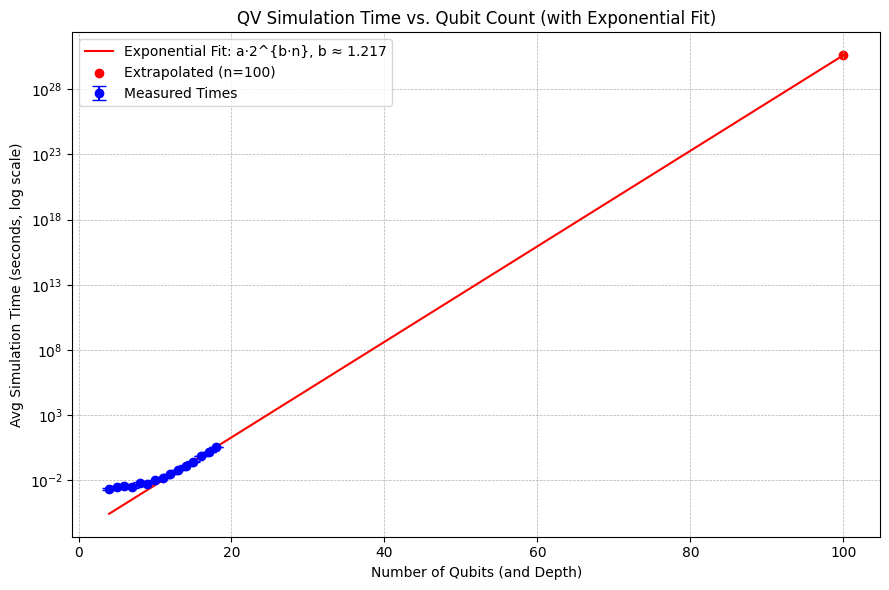

In [306]:
measure_qv_simulation_time(min_qubits=4, max_qubits=18, repeats=3, extrapolate_to=100)

### Quantum Computational limit

If the QV simulation for 100 qubits could be run on all of the computers in the world. 

Assuming ideal connectivity etc. then it would run 10 orders of magnitude faster... 

reducing the runtime from ~$10^{28}$ seconds to ~$10^{18}$ seconds...

However, the age of the universe is $4\times10^{17}$ seconds... so it would still take a very very long time...

This is one example of what is interesting about quantum computers...

### Further reading:

Application-Oriented Performance Benchmarks for Quantum Computing - https://arxiv.org/abs/2110.03137

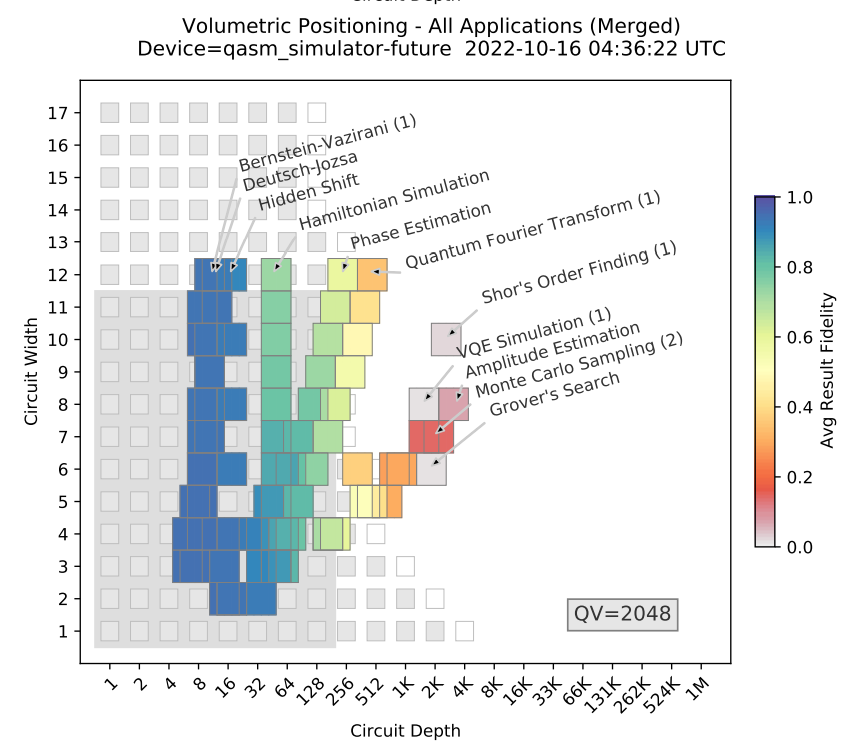

# Exercises

  1. What is the max T1 on ibm_brisbane? Verify it yourself.

  1. What is the maximum T2 on ibm_brisbane? Verify it.

  1. What is the expected largest GHZ state that can be made on ibm_brisbane? How can you determine this?

  1. Can you increase the quantum volume by using different qubits? What is the largest quantum volume you can simulate on ibm_brisbane?

  1. What is the largest quantum volume you can simulate on a classical computer???
  


In [ ]:
'''
Exercise 1
'''


In [ ]:
'''
Exercise 2
'''
